In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Step 1
    transforms.RandomCrop(32, padding=4),


    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

test_transform = transforms.Compose([
    transforms.ToTensor(), # Step 1
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

 ])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 41.7MB/s]


In [ ]:
!cd data
!ls data

Label 3 is class: cat
['cat', 'dog', 'ship', 'airplane']
torch.float32


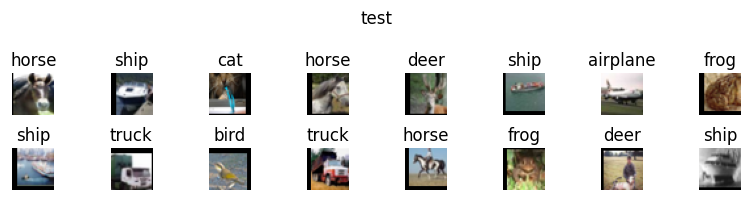

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# List of CIFAR-10 class names (in order of their indices)
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Example usage:
label = 3
print(f"Label {label} is class: {cifar10_classes[label]}")  # Output: cat

# For a batch of labels
labels = [3, 5, 8, 0]
names = [cifar10_classes[l] for l in labels]
print(names)  # Output: ['cat', 'dog', 'ship', 'airplane']

# CIFAR-10 mean and std
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])

def show_batch(images, labels=None, nrow=16,title = None):
    print(images.dtype)
    images = images[:nrow]
    plt.figure(figsize=(nrow//2,2))
    plt.suptitle(title)
    for i in range(len(images)):
        plt.subplot(2, nrow//2, i+1)
        image = images[i].numpy().transpose((1, 2, 0))

        image = std * image + mean
        image = np.clip(image, 0, 1)
        #print(image[1].min())
        plt.imshow(image)
        if labels is not None:
            plt.title(cifar10_classes[int(labels[i].item())])
        plt.axis('off')
    plt.tight_layout()

    plt.show()

images, labels = next(iter(trainloader))
show_batch(images, labels, nrow=16,title = 'test')


In [ ]:
!unzip Imagenet64_val.zip -d Imagenet_val

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def check_accuracy(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    # Calculate accuracy
    correct = (np.array(all_predicted) == np.array(all_labels)).sum()
    total = len(all_labels)
    accuracy = correct / total
    # Calculate precision, recall, and f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predicted, average='macro')

    return accuracy, precision, recall

In [ ]:
from tqdm import tqdm
def train(model, trainloader,testloader, criterion, optimizer, device,scheduler, num_iter):
    model.to(device) # Ensure model is on the correct device inside the function
    test_best_loss = float('inf')
    test_best_acc = 0.0
    model.train()
    for epoch in range(num_iter):
          model.train()
          running_loss = 0.0
          num_train_samples = 0

          test_loss = 0.0
          num_test_samples = 0


          for images, labels in tqdm(trainloader):
              images,labels = images.to(device), labels.to(device)

              optimizer.zero_grad()
              outputs = model(images)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              num_train_samples += images.size(0)
              running_loss += loss.item()

          model.eval()
          for image,labels in tqdm(testloader):
              image,labels = image.to(device), labels.to(device)
              outputs = model(image)
              loss = criterion(outputs,labels)
              test_loss += loss.item()
              num_test_samples += image.size(0)
          scheduler.step()

          test_loss /= len(testloader)
          running_loss /= len(trainloader)



          acc,percision,recall = check_accuracy(model,trainloader,device)
          print(f"Epoch {epoch+1}, train Loss: {running_loss:.4f}")
          print(f"Epoch {epoch+1}, test loss: {test_loss:.4f}")


          #print(f"Model is on device: {next(model.parameters()).device}")
          acc,percision,recall = check_accuracy(model,testloader,device)
          print(f"Epoch {epoch+1},Test Accuracy: {acc} \n"
              f"Epoch {epoch+1},Test Recall: {recall} \n"
              f"Epoch {epoch+1}, Test Percision: {percision}\n")

          if(test_best_loss > test_loss  or test_best_acc < acc):
            test_best_loss = test_loss
            test_best_acc = acc
            print("saving model's weight \n")
            torch.save(model.state_dict(), 'model_weights.pth')

          acc,percision,recall = check_accuracy(model,trainloader,device)
          print(f"Epoch {epoch+1}, Train Accuracy: {acc} \n"
              f"Epoch {epoch+1}, Train Recall: {recall} \n"
              f"Epoch {epoch+1}, Train Percision: {percision}\n")
          #print(f"Images are on device: {images.device}")


In [ ]:
random.seed(1)

NameError: name 'random' is not defined

In [28]:
resnet = models.resnet18(pretrained=False, num_classes=10)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
print(device)

cuda


In [9]:
resnet = torch.compile(resnet)

In [11]:
resnet.to(device)

OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
check_accuracy(resnet,trainloader,device)

W0803 19:52:20.538000 415 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(np.float64(0.1045), 0.03880859673753261, 0.1045)

In [ ]:
print(device)

cuda


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=280)
train(resnet, trainloader,testloader, criterion, optimizer, device,scheduler, num_iter=200)

100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch 1, train Loss: 2.3489
Epoch 1, test loss: 2.2420
Epoch 1,Test Accuracy: 0.3569 
Epoch 1,Test Recall: 0.3569 
Epoch 1, Test Percision: 0.355328412714608

saving model's weight 

Epoch 1, Train Accuracy: 0.33836 
Epoch 1, Train Recall: 0.33836 
Epoch 1, Train Percision: 0.3366702848359214



100%|██████████| 20/20 [00:03<00:00,  6.43it/s]


Epoch 2, train Loss: 1.6784
Epoch 2, test loss: 1.4543
Epoch 2,Test Accuracy: 0.4595 
Epoch 2,Test Recall: 0.45949999999999996 
Epoch 2, Test Percision: 0.4616652674154624

saving model's weight 

Epoch 2, Train Accuracy: 0.43568 
Epoch 2, Train Recall: 0.43567999999999996 
Epoch 2, Train Percision: 0.4441273428529473



100%|██████████| 20/20 [00:02<00:00,  7.29it/s]


Epoch 3, train Loss: 1.4733
Epoch 3, test loss: 1.6160
Epoch 3,Test Accuracy: 0.512 
Epoch 3,Test Recall: 0.512 
Epoch 3, Test Percision: 0.5130991950808964

saving model's weight 

Epoch 3, Train Accuracy: 0.48366 
Epoch 3, Train Recall: 0.48366 
Epoch 3, Train Percision: 0.4968588731431602



100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Epoch 4, train Loss: 1.3342
Epoch 4, test loss: 1.4545
Epoch 4,Test Accuracy: 0.5328 
Epoch 4,Test Recall: 0.5327999999999999 
Epoch 4, Test Percision: 0.5406642537812525

saving model's weight 

Epoch 4, Train Accuracy: 0.51494 
Epoch 4, Train Recall: 0.51494 
Epoch 4, Train Percision: 0.5292556391931209



100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Epoch 5, train Loss: 1.2691
Epoch 5, test loss: 1.1233
Epoch 5,Test Accuracy: 0.6029 
Epoch 5,Test Recall: 0.6029 
Epoch 5, Test Percision: 0.6015226016323983

saving model's weight 

Epoch 5, Train Accuracy: 0.58162 
Epoch 5, Train Recall: 0.5816199999999999 
Epoch 5, Train Percision: 0.5810088142502238



100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


Epoch 6, train Loss: 1.1281
Epoch 6, test loss: 1.0487
Epoch 6,Test Accuracy: 0.6194 
Epoch 6,Test Recall: 0.6194 
Epoch 6, Test Percision: 0.6293148107856152

saving model's weight 

Epoch 6, Train Accuracy: 0.60492 
Epoch 6, Train Recall: 0.6049200000000001 
Epoch 6, Train Percision: 0.6196037273499517



100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Epoch 7, train Loss: 1.0116
Epoch 7, test loss: 1.0161
Epoch 7,Test Accuracy: 0.639 
Epoch 7,Test Recall: 0.6389999999999999 
Epoch 7, Test Percision: 0.6567612778847909

saving model's weight 

Epoch 7, Train Accuracy: 0.6251 
Epoch 7, Train Recall: 0.6251 
Epoch 7, Train Percision: 0.6472340828110695



100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Epoch 8, train Loss: 0.9323
Epoch 8, test loss: 0.9452
Epoch 8,Test Accuracy: 0.6634 
Epoch 8,Test Recall: 0.6634 
Epoch 8, Test Percision: 0.6774969330329909

saving model's weight 

Epoch 8, Train Accuracy: 0.6557 
Epoch 8, Train Recall: 0.6557000000000001 
Epoch 8, Train Percision: 0.6661512679982072



100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Epoch 9, train Loss: 0.8772
Epoch 9, test loss: 0.8926
Epoch 9,Test Accuracy: 0.6898 
Epoch 9,Test Recall: 0.6898 
Epoch 9, Test Percision: 0.7018907588411991

saving model's weight 

Epoch 9, Train Accuracy: 0.67808 
Epoch 9, Train Recall: 0.67808 
Epoch 9, Train Percision: 0.697792749349479



100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Epoch 10, train Loss: 0.8362
Epoch 10, test loss: 0.9880
Epoch 10,Test Accuracy: 0.6644 
Epoch 10,Test Recall: 0.6644 
Epoch 10, Test Percision: 0.7019321197946153

Epoch 10, Train Accuracy: 0.67888 
Epoch 10, Train Recall: 0.67888 
Epoch 10, Train Percision: 0.7047341427010224



100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Epoch 11, train Loss: 0.7978
Epoch 11, test loss: 0.8045
Epoch 11,Test Accuracy: 0.7181 
Epoch 11,Test Recall: 0.7181 
Epoch 11, Test Percision: 0.7306295743014409

saving model's weight 

Epoch 11, Train Accuracy: 0.72144 
Epoch 11, Train Recall: 0.72144 
Epoch 11, Train Percision: 0.7368421630578781



100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


Epoch 12, train Loss: 0.7641
Epoch 12, test loss: 0.8085
Epoch 12,Test Accuracy: 0.7191 
Epoch 12,Test Recall: 0.7191 
Epoch 12, Test Percision: 0.7347655754610947

saving model's weight 

Epoch 12, Train Accuracy: 0.72314 
Epoch 12, Train Recall: 0.7231400000000001 
Epoch 12, Train Percision: 0.7424513672848745



100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


Epoch 13, train Loss: 0.7277
Epoch 13, test loss: 0.7906
Epoch 13,Test Accuracy: 0.7271 
Epoch 13,Test Recall: 0.7271 
Epoch 13, Test Percision: 0.7410093796180416

saving model's weight 

Epoch 13, Train Accuracy: 0.73496 
Epoch 13, Train Recall: 0.7349600000000001 
Epoch 13, Train Percision: 0.7514943334221673



100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Epoch 14, train Loss: 0.6998
Epoch 14, test loss: 0.7636
Epoch 14,Test Accuracy: 0.7347 
Epoch 14,Test Recall: 0.7346999999999999 
Epoch 14, Test Percision: 0.7500055537509217

saving model's weight 

Epoch 14, Train Accuracy: 0.74248 
Epoch 14, Train Recall: 0.74248 
Epoch 14, Train Percision: 0.7598115523598008



100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


Epoch 15, train Loss: 0.6794
Epoch 15, test loss: 0.7525
Epoch 15,Test Accuracy: 0.7438 
Epoch 15,Test Recall: 0.7438 
Epoch 15, Test Percision: 0.7439870139486724

saving model's weight 

Epoch 15, Train Accuracy: 0.75096 
Epoch 15, Train Recall: 0.7509600000000001 
Epoch 15, Train Percision: 0.7547262383777076



100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


Epoch 16, train Loss: 0.6541
Epoch 16, test loss: 0.7263
Epoch 16,Test Accuracy: 0.756 
Epoch 16,Test Recall: 0.756 
Epoch 16, Test Percision: 0.763590546843607

saving model's weight 

Epoch 16, Train Accuracy: 0.76692 
Epoch 16, Train Recall: 0.76692 
Epoch 16, Train Percision: 0.774634802047603



100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Epoch 17, train Loss: 0.6313
Epoch 17, test loss: 0.7435
Epoch 17,Test Accuracy: 0.7453 
Epoch 17,Test Recall: 0.7453000000000001 
Epoch 17, Test Percision: 0.753042406467224

Epoch 17, Train Accuracy: 0.75528 
Epoch 17, Train Recall: 0.75528 
Epoch 17, Train Percision: 0.7641639443800535



100%|██████████| 20/20 [00:02<00:00,  7.04it/s]


Epoch 18, train Loss: 0.6146
Epoch 18, test loss: 0.6878
Epoch 18,Test Accuracy: 0.7637 
Epoch 18,Test Recall: 0.7637 
Epoch 18, Test Percision: 0.7653502459231367

saving model's weight 

Epoch 18, Train Accuracy: 0.78358 
Epoch 18, Train Recall: 0.78358 
Epoch 18, Train Percision: 0.7863865033942625



100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Epoch 19, train Loss: 0.6013
Epoch 19, test loss: 0.7403
Epoch 19,Test Accuracy: 0.7475 
Epoch 19,Test Recall: 0.7474999999999999 
Epoch 19, Test Percision: 0.7657018275245862

Epoch 19, Train Accuracy: 0.7607 
Epoch 19, Train Recall: 0.7606999999999999 
Epoch 19, Train Percision: 0.7787178135471517



100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Epoch 20, train Loss: 0.5953
Epoch 20, test loss: 0.6726
Epoch 20,Test Accuracy: 0.7721 
Epoch 20,Test Recall: 0.7720999999999999 
Epoch 20, Test Percision: 0.7723291242123207

saving model's weight 

Epoch 20, Train Accuracy: 0.78942 
Epoch 20, Train Recall: 0.78942 
Epoch 20, Train Percision: 0.7909973830182994



100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Epoch 21, train Loss: 0.5734
Epoch 21, test loss: 0.7232
Epoch 21,Test Accuracy: 0.7562 
Epoch 21,Test Recall: 0.7562 
Epoch 21, Test Percision: 0.7713692564358081

Epoch 21, Train Accuracy: 0.76878 
Epoch 21, Train Recall: 0.76878 
Epoch 21, Train Percision: 0.7875913477948109



100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


Epoch 22, train Loss: 0.5610
Epoch 22, test loss: 0.7146
Epoch 22,Test Accuracy: 0.7597 
Epoch 22,Test Recall: 0.7596999999999999 
Epoch 22, Test Percision: 0.773432770530923

Epoch 22, Train Accuracy: 0.78236 
Epoch 22, Train Recall: 0.7823599999999999 
Epoch 22, Train Percision: 0.7973840689314367



100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Epoch 23, train Loss: 0.5431
Epoch 23, test loss: 0.6705
Epoch 23,Test Accuracy: 0.7782 
Epoch 23,Test Recall: 0.7782 
Epoch 23, Test Percision: 0.7935875725739671

saving model's weight 

Epoch 23, Train Accuracy: 0.79346 
Epoch 23, Train Recall: 0.7934599999999998 
Epoch 23, Train Percision: 0.8091841627730467



100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Epoch 24, train Loss: 0.5388
Epoch 24, test loss: 0.6451
Epoch 24,Test Accuracy: 0.7802 
Epoch 24,Test Recall: 0.7802 
Epoch 24, Test Percision: 0.783742774971845

saving model's weight 

Epoch 24, Train Accuracy: 0.80726 
Epoch 24, Train Recall: 0.80726 
Epoch 24, Train Percision: 0.8109623392398853



100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Epoch 25, train Loss: 0.5249
Epoch 25, test loss: 0.6521
Epoch 25,Test Accuracy: 0.7754 
Epoch 25,Test Recall: 0.7754 
Epoch 25, Test Percision: 0.7820328889044241

Epoch 25, Train Accuracy: 0.8051 
Epoch 25, Train Recall: 0.8051 
Epoch 25, Train Percision: 0.8128134959446536



100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


Epoch 26, train Loss: 0.5195
Epoch 26, test loss: 0.6985
Epoch 26,Test Accuracy: 0.7647 
Epoch 26,Test Recall: 0.7647 
Epoch 26, Test Percision: 0.7793533066387365

Epoch 26, Train Accuracy: 0.78048 
Epoch 26, Train Recall: 0.78048 
Epoch 26, Train Percision: 0.7976596842599929



100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


Epoch 27, train Loss: 0.5117
Epoch 27, test loss: 0.6697
Epoch 27,Test Accuracy: 0.7744 
Epoch 27,Test Recall: 0.7744000000000001 
Epoch 27, Test Percision: 0.8010211237367454

Epoch 27, Train Accuracy: 0.79914 
Epoch 27, Train Recall: 0.7991400000000001 
Epoch 27, Train Percision: 0.8268000970914586



100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


Epoch 28, train Loss: 0.5094
Epoch 28, test loss: 0.6233
Epoch 28,Test Accuracy: 0.7891 
Epoch 28,Test Recall: 0.7891 
Epoch 28, Test Percision: 0.7933894373996742

saving model's weight 

Epoch 28, Train Accuracy: 0.81868 
Epoch 28, Train Recall: 0.81868 
Epoch 28, Train Percision: 0.8232365066677765



100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


Epoch 29, train Loss: 0.4924
Epoch 29, test loss: 0.6876
Epoch 29,Test Accuracy: 0.7645 
Epoch 29,Test Recall: 0.7645000000000001 
Epoch 29, Test Percision: 0.7866817064820439

Epoch 29, Train Accuracy: 0.79572 
Epoch 29, Train Recall: 0.79572 
Epoch 29, Train Percision: 0.8182929873067863



100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


Epoch 30, train Loss: 0.4969
Epoch 30, test loss: 0.6803
Epoch 30,Test Accuracy: 0.7748 
Epoch 30,Test Recall: 0.7748000000000002 
Epoch 30, Test Percision: 0.7863135832550612

Epoch 30, Train Accuracy: 0.80632 
Epoch 30, Train Recall: 0.80632 
Epoch 30, Train Percision: 0.8176521573776634



100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


Epoch 31, train Loss: 0.4853
Epoch 31, test loss: 0.6714
Epoch 31,Test Accuracy: 0.7736 
Epoch 31,Test Recall: 0.7736 
Epoch 31, Test Percision: 0.7968403172186943

Epoch 31, Train Accuracy: 0.80266 
Epoch 31, Train Recall: 0.80266 
Epoch 31, Train Percision: 0.8230840752404844



100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


Epoch 32, train Loss: 0.4746
Epoch 32, test loss: 0.5888
Epoch 32,Test Accuracy: 0.8014 
Epoch 32,Test Recall: 0.8013999999999999 
Epoch 32, Test Percision: 0.8055692427071813

saving model's weight 

Epoch 32, Train Accuracy: 0.83184 
Epoch 32, Train Recall: 0.83184 
Epoch 32, Train Percision: 0.8353891420226451



100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Epoch 33, train Loss: 0.4609
Epoch 33, test loss: 0.5755
Epoch 33,Test Accuracy: 0.8083 
Epoch 33,Test Recall: 0.8083 
Epoch 33, Test Percision: 0.8093937752719101

saving model's weight 

Epoch 33, Train Accuracy: 0.83342 
Epoch 33, Train Recall: 0.8334199999999999 
Epoch 33, Train Percision: 0.8335632891579958



100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Epoch 34, train Loss: 0.4649
Epoch 34, test loss: 0.6679
Epoch 34,Test Accuracy: 0.7788 
Epoch 34,Test Recall: 0.7788 
Epoch 34, Test Percision: 0.7974043343389273

Epoch 34, Train Accuracy: 0.80234 
Epoch 34, Train Recall: 0.80234 
Epoch 34, Train Percision: 0.8201746069350284



100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Epoch 35, train Loss: 0.4629
Epoch 35, test loss: 0.6572
Epoch 35,Test Accuracy: 0.7759 
Epoch 35,Test Recall: 0.7759 
Epoch 35, Test Percision: 0.784489330193151

Epoch 35, Train Accuracy: 0.80802 
Epoch 35, Train Recall: 0.80802 
Epoch 35, Train Percision: 0.8192788331232883



100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Epoch 36, train Loss: 0.4573
Epoch 36, test loss: 0.5685
Epoch 36,Test Accuracy: 0.8111 
Epoch 36,Test Recall: 0.8111 
Epoch 36, Test Percision: 0.816568860888227

saving model's weight 

Epoch 36, Train Accuracy: 0.8437 
Epoch 36, Train Recall: 0.8436999999999999 
Epoch 36, Train Percision: 0.8479614989117973



100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Epoch 37, train Loss: 0.4492
Epoch 37, test loss: 0.5497
Epoch 37,Test Accuracy: 0.8177 
Epoch 37,Test Recall: 0.8177 
Epoch 37, Test Percision: 0.8216334164742184

saving model's weight 

Epoch 37, Train Accuracy: 0.85 
Epoch 37, Train Recall: 0.85 
Epoch 37, Train Percision: 0.854067575819623



100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Epoch 38, train Loss: 0.4468
Epoch 38, test loss: 0.6996
Epoch 38,Test Accuracy: 0.773 
Epoch 38,Test Recall: 0.7729999999999999 
Epoch 38, Test Percision: 0.7953897386412117

Epoch 38, Train Accuracy: 0.8021 
Epoch 38, Train Recall: 0.8020999999999999 
Epoch 38, Train Percision: 0.8239323578495416



100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Epoch 39, train Loss: 0.4467
Epoch 39, test loss: 0.6035
Epoch 39,Test Accuracy: 0.7996 
Epoch 39,Test Recall: 0.7996000000000001 
Epoch 39, Test Percision: 0.8063463878474083

Epoch 39, Train Accuracy: 0.83594 
Epoch 39, Train Recall: 0.8359399999999999 
Epoch 39, Train Percision: 0.8427195076716218



100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Epoch 40, train Loss: 0.4347
Epoch 40, test loss: 0.6737
Epoch 40,Test Accuracy: 0.7816 
Epoch 40,Test Recall: 0.7816000000000001 
Epoch 40, Test Percision: 0.7913448607188376

Epoch 40, Train Accuracy: 0.81476 
Epoch 40, Train Recall: 0.81476 
Epoch 40, Train Percision: 0.8251416461448976



100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Epoch 41, train Loss: 0.4255
Epoch 41, test loss: 0.6722
Epoch 41,Test Accuracy: 0.7829 
Epoch 41,Test Recall: 0.7828999999999999 
Epoch 41, Test Percision: 0.7907389325024583

Epoch 41, Train Accuracy: 0.82006 
Epoch 41, Train Recall: 0.82006 
Epoch 41, Train Percision: 0.8256728436352742



100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Epoch 42, train Loss: 0.4308
Epoch 42, test loss: 0.6475
Epoch 42,Test Accuracy: 0.7875 
Epoch 42,Test Recall: 0.7875 
Epoch 42, Test Percision: 0.8036010526314883

Epoch 42, Train Accuracy: 0.82482 
Epoch 42, Train Recall: 0.8248200000000001 
Epoch 42, Train Percision: 0.8363291672034157



100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Epoch 43, train Loss: 0.4217
Epoch 43, test loss: 0.7402
Epoch 43,Test Accuracy: 0.7564 
Epoch 43,Test Recall: 0.7564 
Epoch 43, Test Percision: 0.7898847311703814

Epoch 43, Train Accuracy: 0.7788 
Epoch 43, Train Recall: 0.7788000000000002 
Epoch 43, Train Percision: 0.814885487636974



100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Epoch 44, train Loss: 0.4208
Epoch 44, test loss: 0.6543
Epoch 44,Test Accuracy: 0.7881 
Epoch 44,Test Recall: 0.7881 
Epoch 44, Test Percision: 0.8024109208387905

Epoch 44, Train Accuracy: 0.82002 
Epoch 44, Train Recall: 0.8200200000000001 
Epoch 44, Train Percision: 0.8351707933098872



100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Epoch 45, train Loss: 0.4181
Epoch 45, test loss: 0.6563
Epoch 45,Test Accuracy: 0.7887 
Epoch 45,Test Recall: 0.7887 
Epoch 45, Test Percision: 0.8029719895356658

Epoch 45, Train Accuracy: 0.82958 
Epoch 45, Train Recall: 0.82958 
Epoch 45, Train Percision: 0.838473890421078



100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Epoch 46, train Loss: 0.4132
Epoch 46, test loss: 0.6885
Epoch 46,Test Accuracy: 0.7759 
Epoch 46,Test Recall: 0.7759 
Epoch 46, Test Percision: 0.7894706857020622

Epoch 46, Train Accuracy: 0.81394 
Epoch 46, Train Recall: 0.81394 
Epoch 46, Train Percision: 0.8263106044022678



100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Epoch 47, train Loss: 0.4091
Epoch 47, test loss: 0.6499
Epoch 47,Test Accuracy: 0.7929 
Epoch 47,Test Recall: 0.7928999999999999 
Epoch 47, Test Percision: 0.8018613641279023

Epoch 47, Train Accuracy: 0.8283 
Epoch 47, Train Recall: 0.8282999999999999 
Epoch 47, Train Percision: 0.836063607626992



100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Epoch 48, train Loss: 0.4078
Epoch 48, test loss: 0.6292
Epoch 48,Test Accuracy: 0.7922 
Epoch 48,Test Recall: 0.7922 
Epoch 48, Test Percision: 0.8013460643073301

Epoch 48, Train Accuracy: 0.84012 
Epoch 48, Train Recall: 0.8401200000000001 
Epoch 48, Train Percision: 0.8460209756893636



100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Epoch 49, train Loss: 0.4030
Epoch 49, test loss: 0.6134
Epoch 49,Test Accuracy: 0.8006 
Epoch 49,Test Recall: 0.8006 
Epoch 49, Test Percision: 0.8061268650479774

Epoch 49, Train Accuracy: 0.83938 
Epoch 49, Train Recall: 0.8393799999999999 
Epoch 49, Train Percision: 0.8453211192963002



100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Epoch 50, train Loss: 0.3967
Epoch 50, test loss: 0.5636
Epoch 50,Test Accuracy: 0.8134 
Epoch 50,Test Recall: 0.8134 
Epoch 50, Test Percision: 0.8163078916313641

Epoch 50, Train Accuracy: 0.8624 
Epoch 50, Train Recall: 0.8624 
Epoch 50, Train Percision: 0.8642037489357921



100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Epoch 51, train Loss: 0.3920
Epoch 51, test loss: 0.5947
Epoch 51,Test Accuracy: 0.8078 
Epoch 51,Test Recall: 0.8078 
Epoch 51, Test Percision: 0.8131825253774903

Epoch 51, Train Accuracy: 0.85198 
Epoch 51, Train Recall: 0.85198 
Epoch 51, Train Percision: 0.8570380802668105



100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Epoch 52, train Loss: 0.3990
Epoch 52, test loss: 0.5696
Epoch 52,Test Accuracy: 0.8108 
Epoch 52,Test Recall: 0.8108000000000001 
Epoch 52, Test Percision: 0.8145698963168305

Epoch 52, Train Accuracy: 0.8572 
Epoch 52, Train Recall: 0.8572000000000001 
Epoch 52, Train Percision: 0.8591476391904489



100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Epoch 53, train Loss: 0.3847
Epoch 53, test loss: 0.6549
Epoch 53,Test Accuracy: 0.7891 
Epoch 53,Test Recall: 0.7891 
Epoch 53, Test Percision: 0.798796992861163

Epoch 53, Train Accuracy: 0.83058 
Epoch 53, Train Recall: 0.83058 
Epoch 53, Train Percision: 0.8405518389100448



100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Epoch 54, train Loss: 0.3835
Epoch 54, test loss: 0.5849
Epoch 54,Test Accuracy: 0.8114 
Epoch 54,Test Recall: 0.8113999999999999 
Epoch 54, Test Percision: 0.8193541841284716

Epoch 54, Train Accuracy: 0.84828 
Epoch 54, Train Recall: 0.8482799999999999 
Epoch 54, Train Percision: 0.8583007830426548



100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


Epoch 55, train Loss: 0.3831
Epoch 55, test loss: 0.5898
Epoch 55,Test Accuracy: 0.8043 
Epoch 55,Test Recall: 0.8043000000000001 
Epoch 55, Test Percision: 0.8164515042946382

Epoch 55, Train Accuracy: 0.84898 
Epoch 55, Train Recall: 0.8489800000000001 
Epoch 55, Train Percision: 0.8605707377762997



100%|██████████| 20/20 [00:02<00:00,  7.44it/s]


Epoch 56, train Loss: 0.3802
Epoch 56, test loss: 0.5937
Epoch 56,Test Accuracy: 0.8044 
Epoch 56,Test Recall: 0.8044 
Epoch 56, Test Percision: 0.8153990111291423

Epoch 56, Train Accuracy: 0.8402 
Epoch 56, Train Recall: 0.8402 
Epoch 56, Train Percision: 0.8509934260350093



100%|██████████| 20/20 [00:03<00:00,  6.23it/s]


Epoch 57, train Loss: 0.3784
Epoch 57, test loss: 0.5893
Epoch 57,Test Accuracy: 0.8075 
Epoch 57,Test Recall: 0.8074999999999999 
Epoch 57, Test Percision: 0.8097433652624602

Epoch 57, Train Accuracy: 0.84296 
Epoch 57, Train Recall: 0.84296 
Epoch 57, Train Percision: 0.8473040683780116



100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


Epoch 58, train Loss: 0.3684
Epoch 58, test loss: 0.5448
Epoch 58,Test Accuracy: 0.8242 
Epoch 58,Test Recall: 0.8242 
Epoch 58, Test Percision: 0.8283288153176448

saving model's weight 

Epoch 58, Train Accuracy: 0.86786 
Epoch 58, Train Recall: 0.8678600000000001 
Epoch 58, Train Percision: 0.8728064702728346



100%|██████████| 20/20 [00:02<00:00,  6.70it/s]


Epoch 59, train Loss: 0.3732
Epoch 59, test loss: 0.5555
Epoch 59,Test Accuracy: 0.8138 
Epoch 59,Test Recall: 0.8138 
Epoch 59, Test Percision: 0.817865245863526

Epoch 59, Train Accuracy: 0.85112 
Epoch 59, Train Recall: 0.8511200000000001 
Epoch 59, Train Percision: 0.8567765219528448



100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


Epoch 60, train Loss: 0.3733
Epoch 60, test loss: 0.5697
Epoch 60,Test Accuracy: 0.8155 
Epoch 60,Test Recall: 0.8154999999999999 
Epoch 60, Test Percision: 0.8199767631646141

Epoch 60, Train Accuracy: 0.86132 
Epoch 60, Train Recall: 0.8613200000000001 
Epoch 60, Train Percision: 0.8659588247923222



100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


Epoch 61, train Loss: 0.3737
Epoch 61, test loss: 0.6192
Epoch 61,Test Accuracy: 0.8048 
Epoch 61,Test Recall: 0.8048 
Epoch 61, Test Percision: 0.8192316032403786

Epoch 61, Train Accuracy: 0.84408 
Epoch 61, Train Recall: 0.8440799999999999 
Epoch 61, Train Percision: 0.856034869183375



100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Epoch 62, train Loss: 0.3694
Epoch 62, test loss: 0.5809
Epoch 62,Test Accuracy: 0.8132 
Epoch 62,Test Recall: 0.8132000000000001 
Epoch 62, Test Percision: 0.8192513545137396

Epoch 62, Train Accuracy: 0.85334 
Epoch 62, Train Recall: 0.85334 
Epoch 62, Train Percision: 0.8607897643334679



100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Epoch 63, train Loss: 0.3602
Epoch 63, test loss: 0.5631
Epoch 63,Test Accuracy: 0.8199 
Epoch 63,Test Recall: 0.8199 
Epoch 63, Test Percision: 0.8201988205611845

Epoch 63, Train Accuracy: 0.86522 
Epoch 63, Train Recall: 0.8652200000000001 
Epoch 63, Train Percision: 0.8674330206538741



100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Epoch 64, train Loss: 0.3578
Epoch 64, test loss: 0.5555
Epoch 64,Test Accuracy: 0.8118 
Epoch 64,Test Recall: 0.8118000000000001 
Epoch 64, Test Percision: 0.8160354372229369

Epoch 64, Train Accuracy: 0.86274 
Epoch 64, Train Recall: 0.86274 
Epoch 64, Train Percision: 0.8664756984608737



100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Epoch 65, train Loss: 0.3579
Epoch 65, test loss: 0.6391
Epoch 65,Test Accuracy: 0.7949 
Epoch 65,Test Recall: 0.7948999999999999 
Epoch 65, Test Percision: 0.8087585855962305

Epoch 65, Train Accuracy: 0.83882 
Epoch 65, Train Recall: 0.8388200000000001 
Epoch 65, Train Percision: 0.8521494548655498



100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Epoch 66, train Loss: 0.3557
Epoch 66, test loss: 0.5614
Epoch 66,Test Accuracy: 0.8156 
Epoch 66,Test Recall: 0.8156000000000001 
Epoch 66, Test Percision: 0.8211564832467486

Epoch 66, Train Accuracy: 0.85948 
Epoch 66, Train Recall: 0.8594800000000001 
Epoch 66, Train Percision: 0.8651068565269758



100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Epoch 67, train Loss: 0.3559
Epoch 67, test loss: 0.5712
Epoch 67,Test Accuracy: 0.8154 
Epoch 67,Test Recall: 0.8154 
Epoch 67, Test Percision: 0.8215200995409562

Epoch 67, Train Accuracy: 0.86374 
Epoch 67, Train Recall: 0.86374 
Epoch 67, Train Percision: 0.8698870506705246



100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Epoch 68, train Loss: 0.3518
Epoch 68, test loss: 0.6359
Epoch 68,Test Accuracy: 0.7962 
Epoch 68,Test Recall: 0.7962 
Epoch 68, Test Percision: 0.8147742331725201

Epoch 68, Train Accuracy: 0.8415 
Epoch 68, Train Recall: 0.8414999999999999 
Epoch 68, Train Percision: 0.858599212782439



100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


Epoch 69, train Loss: 0.3448
Epoch 69, test loss: 0.6055
Epoch 69,Test Accuracy: 0.804 
Epoch 69,Test Recall: 0.8039999999999999 
Epoch 69, Test Percision: 0.8253003740019382

Epoch 69, Train Accuracy: 0.85142 
Epoch 69, Train Recall: 0.8514200000000001 
Epoch 69, Train Percision: 0.8724727755923499



100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


Epoch 70, train Loss: 0.3487
Epoch 70, test loss: 0.6001
Epoch 70,Test Accuracy: 0.8069 
Epoch 70,Test Recall: 0.8069 
Epoch 70, Test Percision: 0.8111866001917554

Epoch 70, Train Accuracy: 0.85836 
Epoch 70, Train Recall: 0.85836 
Epoch 70, Train Percision: 0.8631324999039481



100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Epoch 71, train Loss: 0.3424
Epoch 71, test loss: 0.6337
Epoch 71,Test Accuracy: 0.7959 
Epoch 71,Test Recall: 0.7959 
Epoch 71, Test Percision: 0.8147948502707859

Epoch 71, Train Accuracy: 0.85282 
Epoch 71, Train Recall: 0.85282 
Epoch 71, Train Percision: 0.8673787545323133



100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Epoch 72, train Loss: 0.3461
Epoch 72, test loss: 0.6677
Epoch 72,Test Accuracy: 0.7885 
Epoch 72,Test Recall: 0.7885000000000001 
Epoch 72, Test Percision: 0.8042862528547932

Epoch 72, Train Accuracy: 0.83966 
Epoch 72, Train Recall: 0.83966 
Epoch 72, Train Percision: 0.8536337656502815



100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Epoch 73, train Loss: 0.3335
Epoch 73, test loss: 0.5696
Epoch 73,Test Accuracy: 0.815 
Epoch 73,Test Recall: 0.8150000000000001 
Epoch 73, Test Percision: 0.8184237726486397

Epoch 73, Train Accuracy: 0.86868 
Epoch 73, Train Recall: 0.86868 
Epoch 73, Train Percision: 0.8723274766404131



100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Epoch 74, train Loss: 0.3330
Epoch 74, test loss: 0.5908
Epoch 74,Test Accuracy: 0.8116 
Epoch 74,Test Recall: 0.8116 
Epoch 74, Test Percision: 0.8206876342718026

Epoch 74, Train Accuracy: 0.8583 
Epoch 74, Train Recall: 0.8583000000000001 
Epoch 74, Train Percision: 0.8677825693125729



100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Epoch 75, train Loss: 0.3357
Epoch 75, test loss: 0.5600
Epoch 75,Test Accuracy: 0.8227 
Epoch 75,Test Recall: 0.8227 
Epoch 75, Test Percision: 0.8304225139797715

Epoch 75, Train Accuracy: 0.87494 
Epoch 75, Train Recall: 0.8749399999999999 
Epoch 75, Train Percision: 0.8792173965109514



100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Epoch 76, train Loss: 0.3360
Epoch 76, test loss: 0.5967
Epoch 76,Test Accuracy: 0.8156 
Epoch 76,Test Recall: 0.8156000000000001 
Epoch 76, Test Percision: 0.8178201255491431

Epoch 76, Train Accuracy: 0.87102 
Epoch 76, Train Recall: 0.87102 
Epoch 76, Train Percision: 0.8728588412841216



100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Epoch 77, train Loss: 0.3229
Epoch 77, test loss: 0.5687
Epoch 77,Test Accuracy: 0.8187 
Epoch 77,Test Recall: 0.8187 
Epoch 77, Test Percision: 0.8229644717223366

Epoch 77, Train Accuracy: 0.87218 
Epoch 77, Train Recall: 0.87218 
Epoch 77, Train Percision: 0.8750157297703602



100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Epoch 78, train Loss: 0.3339
Epoch 78, test loss: 0.5636
Epoch 78,Test Accuracy: 0.8212 
Epoch 78,Test Recall: 0.8211999999999999 
Epoch 78, Test Percision: 0.8268940578253192

Epoch 78, Train Accuracy: 0.87404 
Epoch 78, Train Recall: 0.8740400000000002 
Epoch 78, Train Percision: 0.8779908103727723



100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Epoch 79, train Loss: 0.3254
Epoch 79, test loss: 0.5383
Epoch 79,Test Accuracy: 0.8332 
Epoch 79,Test Recall: 0.8332 
Epoch 79, Test Percision: 0.8335226623308003

saving model's weight 

Epoch 79, Train Accuracy: 0.8836 
Epoch 79, Train Recall: 0.8836 
Epoch 79, Train Percision: 0.8845688716942013



100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Epoch 80, train Loss: 0.3220
Epoch 80, test loss: 0.5805
Epoch 80,Test Accuracy: 0.8172 
Epoch 80,Test Recall: 0.8171999999999999 
Epoch 80, Test Percision: 0.8182690291768953

Epoch 80, Train Accuracy: 0.87328 
Epoch 80, Train Recall: 0.8732800000000001 
Epoch 80, Train Percision: 0.8746165938614385



100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Epoch 81, train Loss: 0.3249
Epoch 81, test loss: 0.5513
Epoch 81,Test Accuracy: 0.8194 
Epoch 81,Test Recall: 0.8194000000000001 
Epoch 81, Test Percision: 0.8272827811522164

Epoch 81, Train Accuracy: 0.87588 
Epoch 81, Train Recall: 0.8758800000000001 
Epoch 81, Train Percision: 0.8823269907109534



100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Epoch 82, train Loss: 0.3262
Epoch 82, test loss: 0.5529
Epoch 82,Test Accuracy: 0.8202 
Epoch 82,Test Recall: 0.8202 
Epoch 82, Test Percision: 0.8357239626488688

Epoch 82, Train Accuracy: 0.87556 
Epoch 82, Train Recall: 0.8755599999999999 
Epoch 82, Train Percision: 0.8890604898637102



100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Epoch 83, train Loss: 0.3177
Epoch 83, test loss: 0.5534
Epoch 83,Test Accuracy: 0.8238 
Epoch 83,Test Recall: 0.8238 
Epoch 83, Test Percision: 0.8285056027486689

Epoch 83, Train Accuracy: 0.8851 
Epoch 83, Train Recall: 0.8850999999999999 
Epoch 83, Train Percision: 0.8885864599496935



100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Epoch 84, train Loss: 0.3106
Epoch 84, test loss: 0.5589
Epoch 84,Test Accuracy: 0.8211 
Epoch 84,Test Recall: 0.8211 
Epoch 84, Test Percision: 0.8245082871561618

Epoch 84, Train Accuracy: 0.87456 
Epoch 84, Train Recall: 0.87456 
Epoch 84, Train Percision: 0.8788361597565268



100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Epoch 85, train Loss: 0.3084
Epoch 85, test loss: 0.5757
Epoch 85,Test Accuracy: 0.8222 
Epoch 85,Test Recall: 0.8222000000000002 
Epoch 85, Test Percision: 0.8251538041168253

Epoch 85, Train Accuracy: 0.87366 
Epoch 85, Train Recall: 0.8736599999999999 
Epoch 85, Train Percision: 0.8768020858969953



100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Epoch 86, train Loss: 0.3096
Epoch 86, test loss: 0.5866
Epoch 86,Test Accuracy: 0.8195 
Epoch 86,Test Recall: 0.8195 
Epoch 86, Test Percision: 0.825393073339127

Epoch 86, Train Accuracy: 0.86668 
Epoch 86, Train Recall: 0.8666799999999999 
Epoch 86, Train Percision: 0.8731888527467342



100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Epoch 87, train Loss: 0.3147
Epoch 87, test loss: 0.5645
Epoch 87,Test Accuracy: 0.824 
Epoch 87,Test Recall: 0.8240000000000001 
Epoch 87, Test Percision: 0.8304604742382489

Epoch 87, Train Accuracy: 0.87386 
Epoch 87, Train Recall: 0.87386 
Epoch 87, Train Percision: 0.8792709089326495



100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Epoch 88, train Loss: 0.3109
Epoch 88, test loss: 0.5817
Epoch 88,Test Accuracy: 0.8179 
Epoch 88,Test Recall: 0.8178999999999998 
Epoch 88, Test Percision: 0.8268352657328165

Epoch 88, Train Accuracy: 0.87568 
Epoch 88, Train Recall: 0.87568 
Epoch 88, Train Percision: 0.8838631764115885



100%|██████████| 20/20 [00:03<00:00,  6.20it/s]


Epoch 89, train Loss: 0.3000
Epoch 89, test loss: 0.5136
Epoch 89,Test Accuracy: 0.833 
Epoch 89,Test Recall: 0.833 
Epoch 89, Test Percision: 0.8356492017393234

saving model's weight 

Epoch 89, Train Accuracy: 0.89298 
Epoch 89, Train Recall: 0.89298 
Epoch 89, Train Percision: 0.8953196474525376



100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


Epoch 90, train Loss: 0.3062
Epoch 90, test loss: 0.6187
Epoch 90,Test Accuracy: 0.8035 
Epoch 90,Test Recall: 0.8035 
Epoch 90, Test Percision: 0.8205776251099934

Epoch 90, Train Accuracy: 0.85578 
Epoch 90, Train Recall: 0.85578 
Epoch 90, Train Percision: 0.8691671028836714



100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


Epoch 91, train Loss: 0.3043
Epoch 91, test loss: 0.5655
Epoch 91,Test Accuracy: 0.8208 
Epoch 91,Test Recall: 0.8208 
Epoch 91, Test Percision: 0.8262210418052186

Epoch 91, Train Accuracy: 0.88434 
Epoch 91, Train Recall: 0.8843399999999999 
Epoch 91, Train Percision: 0.8879924379933903



100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Epoch 92, train Loss: 0.3047
Epoch 92, test loss: 0.5787
Epoch 92,Test Accuracy: 0.8157 
Epoch 92,Test Recall: 0.8157 
Epoch 92, Test Percision: 0.821518438330688

Epoch 92, Train Accuracy: 0.87946 
Epoch 92, Train Recall: 0.8794599999999999 
Epoch 92, Train Percision: 0.8829492007651606



100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Epoch 93, train Loss: 0.2900
Epoch 93, test loss: 0.5806
Epoch 93,Test Accuracy: 0.8181 
Epoch 93,Test Recall: 0.8181 
Epoch 93, Test Percision: 0.8261402398702057

Epoch 93, Train Accuracy: 0.8782 
Epoch 93, Train Recall: 0.8782 
Epoch 93, Train Percision: 0.8842893136261306



100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Epoch 94, train Loss: 0.2952
Epoch 94, test loss: 0.6740
Epoch 94,Test Accuracy: 0.8001 
Epoch 94,Test Recall: 0.8001000000000001 
Epoch 94, Test Percision: 0.8084540351184742

Epoch 94, Train Accuracy: 0.85224 
Epoch 94, Train Recall: 0.8522399999999999 
Epoch 94, Train Percision: 0.8617381340859008



100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Epoch 95, train Loss: 0.2968
Epoch 95, test loss: 0.5829
Epoch 95,Test Accuracy: 0.8179 
Epoch 95,Test Recall: 0.8179000000000001 
Epoch 95, Test Percision: 0.8242332077875834

Epoch 95, Train Accuracy: 0.89078 
Epoch 95, Train Recall: 0.89078 
Epoch 95, Train Percision: 0.89380199908293



100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Epoch 96, train Loss: 0.2901
Epoch 96, test loss: 0.5654
Epoch 96,Test Accuracy: 0.824 
Epoch 96,Test Recall: 0.8240000000000001 
Epoch 96, Test Percision: 0.8322229771925234

Epoch 96, Train Accuracy: 0.8848 
Epoch 96, Train Recall: 0.8848 
Epoch 96, Train Percision: 0.8891996186338906



100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Epoch 97, train Loss: 0.2912
Epoch 97, test loss: 0.5776
Epoch 97,Test Accuracy: 0.8243 
Epoch 97,Test Recall: 0.8243 
Epoch 97, Test Percision: 0.836129308293582

Epoch 97, Train Accuracy: 0.88748 
Epoch 97, Train Recall: 0.88748 
Epoch 97, Train Percision: 0.8944044064701048



100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Epoch 98, train Loss: 0.2775
Epoch 98, test loss: 0.5368
Epoch 98,Test Accuracy: 0.8335 
Epoch 98,Test Recall: 0.8334999999999999 
Epoch 98, Test Percision: 0.83608945412784

saving model's weight 

Epoch 98, Train Accuracy: 0.89582 
Epoch 98, Train Recall: 0.89582 
Epoch 98, Train Percision: 0.8983718266656544



100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


Epoch 99, train Loss: 0.2894
Epoch 99, test loss: 0.5493
Epoch 99,Test Accuracy: 0.8276 
Epoch 99,Test Recall: 0.8276 
Epoch 99, Test Percision: 0.8302638126096088

Epoch 99, Train Accuracy: 0.88908 
Epoch 99, Train Recall: 0.8890800000000001 
Epoch 99, Train Percision: 0.8922577638023134



100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Epoch 100, train Loss: 0.2809
Epoch 100, test loss: 0.5578
Epoch 100,Test Accuracy: 0.8283 
Epoch 100,Test Recall: 0.8282999999999999 
Epoch 100, Test Percision: 0.8318492990696089

Epoch 100, Train Accuracy: 0.89 
Epoch 100, Train Recall: 0.89 
Epoch 100, Train Percision: 0.8917323900637225



100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Epoch 101, train Loss: 0.2898
Epoch 101, test loss: 0.6296
Epoch 101,Test Accuracy: 0.8076 
Epoch 101,Test Recall: 0.8076000000000001 
Epoch 101, Test Percision: 0.8228886595786203

Epoch 101, Train Accuracy: 0.86114 
Epoch 101, Train Recall: 0.86114 
Epoch 101, Train Percision: 0.8741157010984255



100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Epoch 102, train Loss: 0.2756
Epoch 102, test loss: 0.6125
Epoch 102,Test Accuracy: 0.8132 
Epoch 102,Test Recall: 0.8131999999999999 
Epoch 102, Test Percision: 0.8239675236629029

Epoch 102, Train Accuracy: 0.87504 
Epoch 102, Train Recall: 0.87504 
Epoch 102, Train Percision: 0.8847352164455635



100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Epoch 103, train Loss: 0.2788
Epoch 103, test loss: 0.5317
Epoch 103,Test Accuracy: 0.833 
Epoch 103,Test Recall: 0.833 
Epoch 103, Test Percision: 0.8368248438905237

saving model's weight 

Epoch 103, Train Accuracy: 0.89296 
Epoch 103, Train Recall: 0.8929599999999999 
Epoch 103, Train Percision: 0.8962674681546889



100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


Epoch 104, train Loss: 0.2690
Epoch 104, test loss: 0.6099
Epoch 104,Test Accuracy: 0.8171 
Epoch 104,Test Recall: 0.8170999999999999 
Epoch 104, Test Percision: 0.8226036825069023

Epoch 104, Train Accuracy: 0.88178 
Epoch 104, Train Recall: 0.88178 
Epoch 104, Train Percision: 0.8874403475344872



100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Epoch 105, train Loss: 0.2692
Epoch 105, test loss: 0.5727
Epoch 105,Test Accuracy: 0.8268 
Epoch 105,Test Recall: 0.8268000000000001 
Epoch 105, Test Percision: 0.8377311389440424

Epoch 105, Train Accuracy: 0.88774 
Epoch 105, Train Recall: 0.88774 
Epoch 105, Train Percision: 0.8956796962722116



100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


Epoch 106, train Loss: 0.2739
Epoch 106, test loss: 0.5483
Epoch 106,Test Accuracy: 0.828 
Epoch 106,Test Recall: 0.8280000000000001 
Epoch 106, Test Percision: 0.8277153344652168

Epoch 106, Train Accuracy: 0.89988 
Epoch 106, Train Recall: 0.8998799999999999 
Epoch 106, Train Percision: 0.9008905412881297



100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


Epoch 107, train Loss: 0.2710
Epoch 107, test loss: 0.6576
Epoch 107,Test Accuracy: 0.8013 
Epoch 107,Test Recall: 0.8013 
Epoch 107, Test Percision: 0.8100279437594485

Epoch 107, Train Accuracy: 0.85898 
Epoch 107, Train Recall: 0.8589800000000001 
Epoch 107, Train Percision: 0.8659887270958739



100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


Epoch 108, train Loss: 0.2677
Epoch 108, test loss: 0.6027
Epoch 108,Test Accuracy: 0.8175 
Epoch 108,Test Recall: 0.8174999999999999 
Epoch 108, Test Percision: 0.8313837578127765

Epoch 108, Train Accuracy: 0.88028 
Epoch 108, Train Recall: 0.88028 
Epoch 108, Train Percision: 0.8900776915979529



100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Epoch 109, train Loss: 0.2659
Epoch 109, test loss: 0.6156
Epoch 109,Test Accuracy: 0.817 
Epoch 109,Test Recall: 0.817 
Epoch 109, Test Percision: 0.8267445632834228

Epoch 109, Train Accuracy: 0.87796 
Epoch 109, Train Recall: 0.8779600000000001 
Epoch 109, Train Percision: 0.8866095487748025



100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Epoch 110, train Loss: 0.2672
Epoch 110, test loss: 0.5553
Epoch 110,Test Accuracy: 0.8294 
Epoch 110,Test Recall: 0.8294 
Epoch 110, Test Percision: 0.8364808769582991

Epoch 110, Train Accuracy: 0.89962 
Epoch 110, Train Recall: 0.89962 
Epoch 110, Train Percision: 0.9038388500246176



100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Epoch 111, train Loss: 0.2615
Epoch 111, test loss: 0.5745
Epoch 111,Test Accuracy: 0.822 
Epoch 111,Test Recall: 0.8219999999999998 
Epoch 111, Test Percision: 0.8276526742778898

Epoch 111, Train Accuracy: 0.89016 
Epoch 111, Train Recall: 0.8901600000000001 
Epoch 111, Train Percision: 0.8943547248366539



100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


Epoch 112, train Loss: 0.2624
Epoch 112, test loss: 0.6109
Epoch 112,Test Accuracy: 0.8153 
Epoch 112,Test Recall: 0.8153 
Epoch 112, Test Percision: 0.8301740507263302

Epoch 112, Train Accuracy: 0.87086 
Epoch 112, Train Recall: 0.8708600000000001 
Epoch 112, Train Percision: 0.8832313277341687



100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch 113, train Loss: 0.2586
Epoch 113, test loss: 0.5018
Epoch 113,Test Accuracy: 0.8478 
Epoch 113,Test Recall: 0.8478000000000001 
Epoch 113, Test Percision: 0.8468421572108621

saving model's weight 

Epoch 113, Train Accuracy: 0.91374 
Epoch 113, Train Recall: 0.91374 
Epoch 113, Train Percision: 0.9134590988126648



100%|██████████| 20/20 [00:03<00:00,  5.56it/s]


Epoch 114, train Loss: 0.2567
Epoch 114, test loss: 0.6186
Epoch 114,Test Accuracy: 0.82 
Epoch 114,Test Recall: 0.8200000000000001 
Epoch 114, Test Percision: 0.8269424038852804

Epoch 114, Train Accuracy: 0.87094 
Epoch 114, Train Recall: 0.8709399999999998 
Epoch 114, Train Percision: 0.878116330131866



100%|██████████| 20/20 [00:03<00:00,  6.16it/s]


Epoch 115, train Loss: 0.2553
Epoch 115, test loss: 0.5569
Epoch 115,Test Accuracy: 0.8308 
Epoch 115,Test Recall: 0.8308 
Epoch 115, Test Percision: 0.8364861318504421

Epoch 115, Train Accuracy: 0.89774 
Epoch 115, Train Recall: 0.8977400000000001 
Epoch 115, Train Percision: 0.9008931225412535



100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


Epoch 116, train Loss: 0.2525
Epoch 116, test loss: 0.6573
Epoch 116,Test Accuracy: 0.8045 
Epoch 116,Test Recall: 0.8045 
Epoch 116, Test Percision: 0.8150246079094862

Epoch 116, Train Accuracy: 0.88254 
Epoch 116, Train Recall: 0.88254 
Epoch 116, Train Percision: 0.8910650774823047



100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


Epoch 117, train Loss: 0.2489
Epoch 117, test loss: 0.5423
Epoch 117,Test Accuracy: 0.8352 
Epoch 117,Test Recall: 0.8352 
Epoch 117, Test Percision: 0.8413488068523705

Epoch 117, Train Accuracy: 0.90416 
Epoch 117, Train Recall: 0.9041599999999999 
Epoch 117, Train Percision: 0.9069810047355897



100%|██████████| 20/20 [00:02<00:00,  8.12it/s]


Epoch 118, train Loss: 0.2485
Epoch 118, test loss: 0.5883
Epoch 118,Test Accuracy: 0.8205 
Epoch 118,Test Recall: 0.8205 
Epoch 118, Test Percision: 0.8278611523480123

Epoch 118, Train Accuracy: 0.89142 
Epoch 118, Train Recall: 0.8914200000000001 
Epoch 118, Train Percision: 0.8962065901421198



100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


Epoch 119, train Loss: 0.2444
Epoch 119, test loss: 0.5623
Epoch 119,Test Accuracy: 0.8308 
Epoch 119,Test Recall: 0.8308 
Epoch 119, Test Percision: 0.8349895920149188

Epoch 119, Train Accuracy: 0.9022 
Epoch 119, Train Recall: 0.9021999999999999 
Epoch 119, Train Percision: 0.905881670995617



100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Epoch 120, train Loss: 0.2460
Epoch 120, test loss: 0.5703
Epoch 120,Test Accuracy: 0.8279 
Epoch 120,Test Recall: 0.8279 
Epoch 120, Test Percision: 0.8320447909155751

Epoch 120, Train Accuracy: 0.9001 
Epoch 120, Train Recall: 0.9001000000000001 
Epoch 120, Train Percision: 0.9033319454497468



100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Epoch 121, train Loss: 0.2402
Epoch 121, test loss: 0.6054
Epoch 121,Test Accuracy: 0.8224 
Epoch 121,Test Recall: 0.8224 
Epoch 121, Test Percision: 0.8250820986263886

Epoch 121, Train Accuracy: 0.89428 
Epoch 121, Train Recall: 0.8942799999999999 
Epoch 121, Train Percision: 0.8972403651014161



100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Epoch 122, train Loss: 0.2426
Epoch 122, test loss: 0.5175
Epoch 122,Test Accuracy: 0.8465 
Epoch 122,Test Recall: 0.8465 
Epoch 122, Test Percision: 0.848226113455469

Epoch 122, Train Accuracy: 0.91446 
Epoch 122, Train Recall: 0.91446 
Epoch 122, Train Percision: 0.9156327377746735



100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


Epoch 123, train Loss: 0.2328
Epoch 123, test loss: 0.6064
Epoch 123,Test Accuracy: 0.8202 
Epoch 123,Test Recall: 0.8202 
Epoch 123, Test Percision: 0.8255096476909399

Epoch 123, Train Accuracy: 0.89574 
Epoch 123, Train Recall: 0.89574 
Epoch 123, Train Percision: 0.8989336490824066



100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


Epoch 124, train Loss: 0.2357
Epoch 124, test loss: 0.5578
Epoch 124,Test Accuracy: 0.8306 
Epoch 124,Test Recall: 0.8305999999999999 
Epoch 124, Test Percision: 0.8343726508707443

Epoch 124, Train Accuracy: 0.90812 
Epoch 124, Train Recall: 0.90812 
Epoch 124, Train Percision: 0.9106209152737816



100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Epoch 125, train Loss: 0.2356
Epoch 125, test loss: 0.5400
Epoch 125,Test Accuracy: 0.8384 
Epoch 125,Test Recall: 0.8384 
Epoch 125, Test Percision: 0.8375798623512184

Epoch 125, Train Accuracy: 0.9118 
Epoch 125, Train Recall: 0.9117999999999998 
Epoch 125, Train Percision: 0.9123167299836984



100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Epoch 126, train Loss: 0.2252
Epoch 126, test loss: 0.5725
Epoch 126,Test Accuracy: 0.8331 
Epoch 126,Test Recall: 0.8331000000000002 
Epoch 126, Test Percision: 0.8367677903771987

Epoch 126, Train Accuracy: 0.9048 
Epoch 126, Train Recall: 0.9048 
Epoch 126, Train Percision: 0.907192268712452



100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Epoch 127, train Loss: 0.2311
Epoch 127, test loss: 0.5338
Epoch 127,Test Accuracy: 0.8372 
Epoch 127,Test Recall: 0.8371999999999999 
Epoch 127, Test Percision: 0.841969234519891

Epoch 127, Train Accuracy: 0.91234 
Epoch 127, Train Recall: 0.9123400000000002 
Epoch 127, Train Percision: 0.9151108912410247



100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Epoch 128, train Loss: 0.2190
Epoch 128, test loss: 0.5902
Epoch 128,Test Accuracy: 0.8241 
Epoch 128,Test Recall: 0.8240999999999999 
Epoch 128, Test Percision: 0.8322411311476019

Epoch 128, Train Accuracy: 0.89996 
Epoch 128, Train Recall: 0.8999600000000001 
Epoch 128, Train Percision: 0.9043954774560463



100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


Epoch 129, train Loss: 0.2303
Epoch 129, test loss: 0.6755
Epoch 129,Test Accuracy: 0.8049 
Epoch 129,Test Recall: 0.8049 
Epoch 129, Test Percision: 0.8251271568926948

Epoch 129, Train Accuracy: 0.88284 
Epoch 129, Train Recall: 0.8828400000000001 
Epoch 129, Train Percision: 0.8974037319280264



100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Epoch 130, train Loss: 0.2229
Epoch 130, test loss: 0.5751
Epoch 130,Test Accuracy: 0.8305 
Epoch 130,Test Recall: 0.8305 
Epoch 130, Test Percision: 0.8338233222926386

Epoch 130, Train Accuracy: 0.91152 
Epoch 130, Train Recall: 0.91152 
Epoch 130, Train Percision: 0.9135138044062157



100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Epoch 131, train Loss: 0.2176
Epoch 131, test loss: 0.5864
Epoch 131,Test Accuracy: 0.8279 
Epoch 131,Test Recall: 0.8279 
Epoch 131, Test Percision: 0.835428973969036

Epoch 131, Train Accuracy: 0.90568 
Epoch 131, Train Recall: 0.90568 
Epoch 131, Train Percision: 0.909446945389285



100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Epoch 132, train Loss: 0.2274
Epoch 132, test loss: 0.6132
Epoch 132,Test Accuracy: 0.8188 
Epoch 132,Test Recall: 0.8188000000000001 
Epoch 132, Test Percision: 0.8266270227528503

Epoch 132, Train Accuracy: 0.8985 
Epoch 132, Train Recall: 0.8985 
Epoch 132, Train Percision: 0.904112969895672



100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Epoch 133, train Loss: 0.2142
Epoch 133, test loss: 0.6070
Epoch 133,Test Accuracy: 0.8236 
Epoch 133,Test Recall: 0.8236000000000001 
Epoch 133, Test Percision: 0.8318561212329424

Epoch 133, Train Accuracy: 0.90252 
Epoch 133, Train Recall: 0.9025200000000002 
Epoch 133, Train Percision: 0.9071503653356897



100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Epoch 134, train Loss: 0.2169
Epoch 134, test loss: 0.5421
Epoch 134,Test Accuracy: 0.8415 
Epoch 134,Test Recall: 0.8415000000000001 
Epoch 134, Test Percision: 0.8431869258346824

Epoch 134, Train Accuracy: 0.9134 
Epoch 134, Train Recall: 0.9133999999999999 
Epoch 134, Train Percision: 0.9154559230518157



100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Epoch 135, train Loss: 0.2128
Epoch 135, test loss: 0.5975
Epoch 135,Test Accuracy: 0.8204 
Epoch 135,Test Recall: 0.8204 
Epoch 135, Test Percision: 0.8307497317314743

Epoch 135, Train Accuracy: 0.90384 
Epoch 135, Train Recall: 0.90384 
Epoch 135, Train Percision: 0.9094196572101024



100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Epoch 136, train Loss: 0.2116
Epoch 136, test loss: 0.5436
Epoch 136,Test Accuracy: 0.8371 
Epoch 136,Test Recall: 0.8371000000000001 
Epoch 136, Test Percision: 0.8375144373280854

Epoch 136, Train Accuracy: 0.9159 
Epoch 136, Train Recall: 0.9158999999999999 
Epoch 136, Train Percision: 0.9172291142107702



100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Epoch 137, train Loss: 0.2116
Epoch 137, test loss: 0.5769
Epoch 137,Test Accuracy: 0.8333 
Epoch 137,Test Recall: 0.8332999999999998 
Epoch 137, Test Percision: 0.8360562980199868

Epoch 137, Train Accuracy: 0.9155 
Epoch 137, Train Recall: 0.9155000000000001 
Epoch 137, Train Percision: 0.9182177316031485



100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Epoch 138, train Loss: 0.2039
Epoch 138, test loss: 0.5113
Epoch 138,Test Accuracy: 0.8471 
Epoch 138,Test Recall: 0.8471 
Epoch 138, Test Percision: 0.8480764402551004

Epoch 138, Train Accuracy: 0.92818 
Epoch 138, Train Recall: 0.92818 
Epoch 138, Train Percision: 0.9288906122355367



100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Epoch 139, train Loss: 0.2011
Epoch 139, test loss: 0.5770
Epoch 139,Test Accuracy: 0.8345 
Epoch 139,Test Recall: 0.8345 
Epoch 139, Test Percision: 0.8379266807543221

Epoch 139, Train Accuracy: 0.92026 
Epoch 139, Train Recall: 0.9202600000000001 
Epoch 139, Train Percision: 0.92230356573658



100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Epoch 140, train Loss: 0.2101
Epoch 140, test loss: 0.5857
Epoch 140,Test Accuracy: 0.8361 
Epoch 140,Test Recall: 0.8360999999999998 
Epoch 140, Test Percision: 0.8405232060056775

Epoch 140, Train Accuracy: 0.9156 
Epoch 140, Train Recall: 0.9156000000000001 
Epoch 140, Train Percision: 0.9190977316079312



100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Epoch 141, train Loss: 0.2030
Epoch 141, test loss: 0.5194
Epoch 141,Test Accuracy: 0.8468 
Epoch 141,Test Recall: 0.8468 
Epoch 141, Test Percision: 0.8477550265727668

Epoch 141, Train Accuracy: 0.92908 
Epoch 141, Train Recall: 0.9290800000000001 
Epoch 141, Train Percision: 0.9297346537746037



100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Epoch 142, train Loss: 0.1962
Epoch 142, test loss: 0.5584
Epoch 142,Test Accuracy: 0.8382 
Epoch 142,Test Recall: 0.8382000000000002 
Epoch 142, Test Percision: 0.8402365937816327

Epoch 142, Train Accuracy: 0.92134 
Epoch 142, Train Recall: 0.92134 
Epoch 142, Train Percision: 0.9228953682832921



100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Epoch 143, train Loss: 0.1915
Epoch 143, test loss: 0.6127
Epoch 143,Test Accuracy: 0.8254 
Epoch 143,Test Recall: 0.8253999999999999 
Epoch 143, Test Percision: 0.8374269004078917

Epoch 143, Train Accuracy: 0.90508 
Epoch 143, Train Recall: 0.9050799999999999 
Epoch 143, Train Percision: 0.9121366719866332



100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Epoch 144, train Loss: 0.1956
Epoch 144, test loss: 0.6044
Epoch 144,Test Accuracy: 0.8241 
Epoch 144,Test Recall: 0.8240999999999999 
Epoch 144, Test Percision: 0.8326829669289388

Epoch 144, Train Accuracy: 0.90438 
Epoch 144, Train Recall: 0.9043800000000001 
Epoch 144, Train Percision: 0.9090430102519038



100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


Epoch 145, train Loss: 0.1932
Epoch 145, test loss: 0.5453
Epoch 145,Test Accuracy: 0.8434 
Epoch 145,Test Recall: 0.8434000000000001 
Epoch 145, Test Percision: 0.850784017974149

Epoch 145, Train Accuracy: 0.92828 
Epoch 145, Train Recall: 0.92828 
Epoch 145, Train Percision: 0.9320622864186323



100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Epoch 146, train Loss: 0.1863
Epoch 146, test loss: 0.5526
Epoch 146,Test Accuracy: 0.8378 
Epoch 146,Test Recall: 0.8378 
Epoch 146, Test Percision: 0.8422421365106535

Epoch 146, Train Accuracy: 0.92914 
Epoch 146, Train Recall: 0.92914 
Epoch 146, Train Percision: 0.9310729694317141



100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Epoch 147, train Loss: 0.1857
Epoch 147, test loss: 0.5399
Epoch 147,Test Accuracy: 0.8414 
Epoch 147,Test Recall: 0.8414000000000001 
Epoch 147, Test Percision: 0.840973996611293

Epoch 147, Train Accuracy: 0.92982 
Epoch 147, Train Recall: 0.9298200000000001 
Epoch 147, Train Percision: 0.9305444568344294



100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


Epoch 148, train Loss: 0.1915
Epoch 148, test loss: 0.6047
Epoch 148,Test Accuracy: 0.8302 
Epoch 148,Test Recall: 0.8302000000000002 
Epoch 148, Test Percision: 0.8391462769029017

Epoch 148, Train Accuracy: 0.91118 
Epoch 148, Train Recall: 0.9111799999999999 
Epoch 148, Train Percision: 0.9169024544733174



100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Epoch 149, train Loss: 0.1796
Epoch 149, test loss: 0.5483
Epoch 149,Test Accuracy: 0.8414 
Epoch 149,Test Recall: 0.8413999999999999 
Epoch 149, Test Percision: 0.8476659994564383

Epoch 149, Train Accuracy: 0.9262 
Epoch 149, Train Recall: 0.9262 
Epoch 149, Train Percision: 0.9295058800739563



100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


Epoch 150, train Loss: 0.1848
Epoch 150, test loss: 0.5457
Epoch 150,Test Accuracy: 0.8456 
Epoch 150,Test Recall: 0.8456000000000001 
Epoch 150, Test Percision: 0.8488416477725501

Epoch 150, Train Accuracy: 0.93588 
Epoch 150, Train Recall: 0.93588 
Epoch 150, Train Percision: 0.9371529927315125



100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Epoch 151, train Loss: 0.1763
Epoch 151, test loss: 0.5556
Epoch 151,Test Accuracy: 0.8422 
Epoch 151,Test Recall: 0.8422000000000001 
Epoch 151, Test Percision: 0.8450569178083874

Epoch 151, Train Accuracy: 0.92874 
Epoch 151, Train Recall: 0.9287399999999998 
Epoch 151, Train Percision: 0.9307899790775143



100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


Epoch 152, train Loss: 0.1683
Epoch 152, test loss: 0.5541
Epoch 152,Test Accuracy: 0.8446 
Epoch 152,Test Recall: 0.8446 
Epoch 152, Test Percision: 0.8492774790007933

Epoch 152, Train Accuracy: 0.93798 
Epoch 152, Train Recall: 0.9379799999999999 
Epoch 152, Train Percision: 0.9391068188210914



100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Epoch 153, train Loss: 0.1783
Epoch 153, test loss: 0.5524
Epoch 153,Test Accuracy: 0.8408 
Epoch 153,Test Recall: 0.8408000000000001 
Epoch 153, Test Percision: 0.8415450882387205

Epoch 153, Train Accuracy: 0.93364 
Epoch 153, Train Recall: 0.9336399999999999 
Epoch 153, Train Percision: 0.9341178909701174



100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Epoch 154, train Loss: 0.1657
Epoch 154, test loss: 0.5510
Epoch 154,Test Accuracy: 0.8431 
Epoch 154,Test Recall: 0.8431 
Epoch 154, Test Percision: 0.8457951262926369

Epoch 154, Train Accuracy: 0.93212 
Epoch 154, Train Recall: 0.93212 
Epoch 154, Train Percision: 0.9335907294932646



100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Epoch 155, train Loss: 0.1710
Epoch 155, test loss: 0.5601
Epoch 155,Test Accuracy: 0.8429 
Epoch 155,Test Recall: 0.8429 
Epoch 155, Test Percision: 0.8427846909987542

Epoch 155, Train Accuracy: 0.93404 
Epoch 155, Train Recall: 0.9340400000000001 
Epoch 155, Train Percision: 0.9341708453769216



100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


Epoch 156, train Loss: 0.1689
Epoch 156, test loss: 0.5520
Epoch 156,Test Accuracy: 0.846 
Epoch 156,Test Recall: 0.8459999999999999 
Epoch 156, Test Percision: 0.8479194543413587

Epoch 156, Train Accuracy: 0.93184 
Epoch 156, Train Recall: 0.93184 
Epoch 156, Train Percision: 0.9332746431804626



100%|██████████| 20/20 [00:02<00:00,  7.19it/s]


Epoch 157, train Loss: 0.1704
Epoch 157, test loss: 0.5586
Epoch 157,Test Accuracy: 0.8407 
Epoch 157,Test Recall: 0.8407 
Epoch 157, Test Percision: 0.8413863866321897

Epoch 157, Train Accuracy: 0.93138 
Epoch 157, Train Recall: 0.9313800000000001 
Epoch 157, Train Percision: 0.9314360662407349



100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


Epoch 158, train Loss: 0.1629
Epoch 158, test loss: 0.6297
Epoch 158,Test Accuracy: 0.826 
Epoch 158,Test Recall: 0.826 
Epoch 158, Test Percision: 0.8332065470010755

Epoch 158, Train Accuracy: 0.91948 
Epoch 158, Train Recall: 0.9194800000000001 
Epoch 158, Train Percision: 0.9231511270138473



100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


Epoch 159, train Loss: 0.1653
Epoch 159, test loss: 0.6008
Epoch 159,Test Accuracy: 0.8328 
Epoch 159,Test Recall: 0.8328 
Epoch 159, Test Percision: 0.8363659071589196

Epoch 159, Train Accuracy: 0.92576 
Epoch 159, Train Recall: 0.92576 
Epoch 159, Train Percision: 0.9281223482915438



100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


Epoch 160, train Loss: 0.1550
Epoch 160, test loss: 0.5195
Epoch 160,Test Accuracy: 0.8547 
Epoch 160,Test Recall: 0.8547 
Epoch 160, Test Percision: 0.8571482395471337

saving model's weight 

Epoch 160, Train Accuracy: 0.95186 
Epoch 160, Train Recall: 0.9518599999999999 
Epoch 160, Train Percision: 0.9526491618922289



100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Epoch 161, train Loss: 0.1576
Epoch 161, test loss: 0.6269
Epoch 161,Test Accuracy: 0.828 
Epoch 161,Test Recall: 0.828 
Epoch 161, Test Percision: 0.8384042560143466

Epoch 161, Train Accuracy: 0.92044 
Epoch 161, Train Recall: 0.9204399999999999 
Epoch 161, Train Percision: 0.9254799399195862



100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


Epoch 162, train Loss: 0.1499
Epoch 162, test loss: 0.5722
Epoch 162,Test Accuracy: 0.8456 
Epoch 162,Test Recall: 0.8455999999999999 
Epoch 162, Test Percision: 0.8454636778993159

Epoch 162, Train Accuracy: 0.93534 
Epoch 162, Train Recall: 0.9353400000000001 
Epoch 162, Train Percision: 0.9356432344052257



100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


Epoch 163, train Loss: 0.1557
Epoch 163, test loss: 0.5923
Epoch 163,Test Accuracy: 0.8356 
Epoch 163,Test Recall: 0.8356 
Epoch 163, Test Percision: 0.8382139275409475

Epoch 163, Train Accuracy: 0.93382 
Epoch 163, Train Recall: 0.9338200000000001 
Epoch 163, Train Percision: 0.9350952822458689



100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


Epoch 164, train Loss: 0.1560
Epoch 164, test loss: 0.5830
Epoch 164,Test Accuracy: 0.8425 
Epoch 164,Test Recall: 0.8425 
Epoch 164, Test Percision: 0.8448509332259565

Epoch 164, Train Accuracy: 0.93982 
Epoch 164, Train Recall: 0.9398200000000001 
Epoch 164, Train Percision: 0.9409859336243163



100%|██████████| 20/20 [00:02<00:00,  6.92it/s]


Epoch 165, train Loss: 0.1398
Epoch 165, test loss: 0.5789
Epoch 165,Test Accuracy: 0.8427 
Epoch 165,Test Recall: 0.8427000000000001 
Epoch 165, Test Percision: 0.8438404368553847

Epoch 165, Train Accuracy: 0.94002 
Epoch 165, Train Recall: 0.94002 
Epoch 165, Train Percision: 0.9404403793673026



100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch 166, train Loss: 0.1436
Epoch 166, test loss: 0.5759
Epoch 166,Test Accuracy: 0.8395 
Epoch 166,Test Recall: 0.8395000000000001 
Epoch 166, Test Percision: 0.8424034247006883

Epoch 166, Train Accuracy: 0.942 
Epoch 166, Train Recall: 0.942 
Epoch 166, Train Percision: 0.9429363831546949



100%|██████████| 20/20 [00:03<00:00,  6.26it/s]


Epoch 167, train Loss: 0.1390
Epoch 167, test loss: 0.6010
Epoch 167,Test Accuracy: 0.8415 
Epoch 167,Test Recall: 0.8414999999999999 
Epoch 167, Test Percision: 0.8448490214102378

Epoch 167, Train Accuracy: 0.93846 
Epoch 167, Train Recall: 0.9384599999999998 
Epoch 167, Train Percision: 0.939763371381539



100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


Epoch 168, train Loss: 0.1439
Epoch 168, test loss: 0.5700
Epoch 168,Test Accuracy: 0.8437 
Epoch 168,Test Recall: 0.8436999999999999 
Epoch 168, Test Percision: 0.8458723552360574

Epoch 168, Train Accuracy: 0.94634 
Epoch 168, Train Recall: 0.9463399999999998 
Epoch 168, Train Percision: 0.9476292805140625



100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch 169, train Loss: 0.1352
Epoch 169, test loss: 0.5715
Epoch 169,Test Accuracy: 0.8438 
Epoch 169,Test Recall: 0.8438000000000001 
Epoch 169, Test Percision: 0.8474479875671749

Epoch 169, Train Accuracy: 0.93878 
Epoch 169, Train Recall: 0.9387800000000002 
Epoch 169, Train Percision: 0.9402325186797379



100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


Epoch 170, train Loss: 0.1350
Epoch 170, test loss: 0.5857
Epoch 170,Test Accuracy: 0.8469 
Epoch 170,Test Recall: 0.8469 
Epoch 170, Test Percision: 0.8528874910857637

Epoch 170, Train Accuracy: 0.94182 
Epoch 170, Train Recall: 0.9418200000000001 
Epoch 170, Train Percision: 0.9437520403940696



100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


Epoch 171, train Loss: 0.1332
Epoch 171, test loss: 0.6113
Epoch 171,Test Accuracy: 0.8434 
Epoch 171,Test Recall: 0.8433999999999999 
Epoch 171, Test Percision: 0.85614986364861

Epoch 171, Train Accuracy: 0.9384 
Epoch 171, Train Recall: 0.9384 
Epoch 171, Train Percision: 0.9438011877529661



100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


Epoch 172, train Loss: 0.1331
Epoch 172, test loss: 0.5517
Epoch 172,Test Accuracy: 0.852 
Epoch 172,Test Recall: 0.852 
Epoch 172, Test Percision: 0.8547951576884726

Epoch 172, Train Accuracy: 0.94916 
Epoch 172, Train Recall: 0.94916 
Epoch 172, Train Percision: 0.9499168027288588



100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


Epoch 173, train Loss: 0.1247
Epoch 173, test loss: 0.5386
Epoch 173,Test Accuracy: 0.8532 
Epoch 173,Test Recall: 0.8532 
Epoch 173, Test Percision: 0.8586200128191168

Epoch 173, Train Accuracy: 0.95676 
Epoch 173, Train Recall: 0.9567599999999998 
Epoch 173, Train Percision: 0.9575961833130096



100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


Epoch 174, train Loss: 0.1225
Epoch 174, test loss: 0.5699
Epoch 174,Test Accuracy: 0.8504 
Epoch 174,Test Recall: 0.8503999999999999 
Epoch 174, Test Percision: 0.8523382827841001

Epoch 174, Train Accuracy: 0.9479 
Epoch 174, Train Recall: 0.9479 
Epoch 174, Train Percision: 0.948781871619196



100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Epoch 175, train Loss: 0.1267
Epoch 175, test loss: 0.5442
Epoch 175,Test Accuracy: 0.8526 
Epoch 175,Test Recall: 0.8526 
Epoch 175, Test Percision: 0.8535629702738248

Epoch 175, Train Accuracy: 0.95344 
Epoch 175, Train Recall: 0.95344 
Epoch 175, Train Percision: 0.9539566054447904



100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Epoch 176, train Loss: 0.1188
Epoch 176, test loss: 0.5544
Epoch 176,Test Accuracy: 0.8559 
Epoch 176,Test Recall: 0.8559000000000001 
Epoch 176, Test Percision: 0.8561816960795874

saving model's weight 

Epoch 176, Train Accuracy: 0.9563 
Epoch 176, Train Recall: 0.9562999999999999 
Epoch 176, Train Percision: 0.9565471090095305



100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Epoch 177, train Loss: 0.1111
Epoch 177, test loss: 0.5828
Epoch 177,Test Accuracy: 0.8465 
Epoch 177,Test Recall: 0.8465 
Epoch 177, Test Percision: 0.8513101842825513

Epoch 177, Train Accuracy: 0.9518 
Epoch 177, Train Recall: 0.9518000000000001 
Epoch 177, Train Percision: 0.9528196493746176



100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Epoch 178, train Loss: 0.1195
Epoch 178, test loss: 0.5823
Epoch 178,Test Accuracy: 0.8475 
Epoch 178,Test Recall: 0.8474999999999999 
Epoch 178, Test Percision: 0.8490541947854797

Epoch 178, Train Accuracy: 0.95016 
Epoch 178, Train Recall: 0.95016 
Epoch 178, Train Percision: 0.9508938181685387



100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


Epoch 179, train Loss: 0.1196
Epoch 179, test loss: 0.5864
Epoch 179,Test Accuracy: 0.8517 
Epoch 179,Test Recall: 0.8516999999999999 
Epoch 179, Test Percision: 0.8574365464616676

Epoch 179, Train Accuracy: 0.94886 
Epoch 179, Train Recall: 0.9488599999999998 
Epoch 179, Train Percision: 0.9505507327900155



100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Epoch 180, train Loss: 0.1165
Epoch 180, test loss: 0.5726
Epoch 180,Test Accuracy: 0.8576 
Epoch 180,Test Recall: 0.8575999999999999 
Epoch 180, Test Percision: 0.8583781982100378

saving model's weight 

Epoch 180, Train Accuracy: 0.95952 
Epoch 180, Train Recall: 0.95952 
Epoch 180, Train Percision: 0.9600472237475209



100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Epoch 181, train Loss: 0.1116
Epoch 181, test loss: 0.5439
Epoch 181,Test Accuracy: 0.8539 
Epoch 181,Test Recall: 0.8539000000000001 
Epoch 181, Test Percision: 0.8556571934448061

saving model's weight 

Epoch 181, Train Accuracy: 0.96148 
Epoch 181, Train Recall: 0.9614800000000001 
Epoch 181, Train Percision: 0.9617460066332836



100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Epoch 182, train Loss: 0.1096
Epoch 182, test loss: 0.6046
Epoch 182,Test Accuracy: 0.842 
Epoch 182,Test Recall: 0.842 
Epoch 182, Test Percision: 0.8428654687046683

Epoch 182, Train Accuracy: 0.94442 
Epoch 182, Train Recall: 0.94442 
Epoch 182, Train Percision: 0.9450169730919239



100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Epoch 183, train Loss: 0.1113
Epoch 183, test loss: 0.5827
Epoch 183,Test Accuracy: 0.849 
Epoch 183,Test Recall: 0.849 
Epoch 183, Test Percision: 0.8500857480617483

Epoch 183, Train Accuracy: 0.95594 
Epoch 183, Train Recall: 0.95594 
Epoch 183, Train Percision: 0.956662904032479



100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Epoch 184, train Loss: 0.1029
Epoch 184, test loss: 0.5672
Epoch 184,Test Accuracy: 0.8548 
Epoch 184,Test Recall: 0.8548 
Epoch 184, Test Percision: 0.8561448362125388

saving model's weight 

Epoch 184, Train Accuracy: 0.9611 
Epoch 184, Train Recall: 0.9610999999999998 
Epoch 184, Train Percision: 0.9616837834741563



100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Epoch 185, train Loss: 0.1029
Epoch 185, test loss: 0.6041
Epoch 185,Test Accuracy: 0.8455 
Epoch 185,Test Recall: 0.8455 
Epoch 185, Test Percision: 0.8468075850079229

Epoch 185, Train Accuracy: 0.95268 
Epoch 185, Train Recall: 0.95268 
Epoch 185, Train Percision: 0.9532451151963854



100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Epoch 186, train Loss: 0.0980
Epoch 186, test loss: 0.5832
Epoch 186,Test Accuracy: 0.8501 
Epoch 186,Test Recall: 0.8501000000000001 
Epoch 186, Test Percision: 0.8508586503862036

Epoch 186, Train Accuracy: 0.96102 
Epoch 186, Train Recall: 0.9610199999999999 
Epoch 186, Train Percision: 0.9612554535452729



100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


Epoch 187, train Loss: 0.0982
Epoch 187, test loss: 0.6256
Epoch 187,Test Accuracy: 0.8442 
Epoch 187,Test Recall: 0.8442000000000001 
Epoch 187, Test Percision: 0.8465376889377312

Epoch 187, Train Accuracy: 0.95378 
Epoch 187, Train Recall: 0.9537799999999999 
Epoch 187, Train Percision: 0.9544927821769444



100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Epoch 188, train Loss: 0.0949
Epoch 188, test loss: 0.5872
Epoch 188,Test Accuracy: 0.8572 
Epoch 188,Test Recall: 0.8572 
Epoch 188, Test Percision: 0.8588555759610246

saving model's weight 

Epoch 188, Train Accuracy: 0.96198 
Epoch 188, Train Recall: 0.9619800000000002 
Epoch 188, Train Percision: 0.9627730313825074



100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


Epoch 189, train Loss: 0.0932
Epoch 189, test loss: 0.5747
Epoch 189,Test Accuracy: 0.8539 
Epoch 189,Test Recall: 0.8539 
Epoch 189, Test Percision: 0.8557198876366783

saving model's weight 

Epoch 189, Train Accuracy: 0.9656 
Epoch 189, Train Recall: 0.9655999999999999 
Epoch 189, Train Percision: 0.9661059181752558



100%|██████████| 20/20 [00:02<00:00,  7.96it/s]


Epoch 190, train Loss: 0.0926
Epoch 190, test loss: 0.5593
Epoch 190,Test Accuracy: 0.8564 
Epoch 190,Test Recall: 0.8564 
Epoch 190, Test Percision: 0.8574870515358727

saving model's weight 

Epoch 190, Train Accuracy: 0.9675 
Epoch 190, Train Recall: 0.9674999999999999 
Epoch 190, Train Percision: 0.967792808604673



100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Epoch 191, train Loss: 0.0925
Epoch 191, test loss: 0.5962
Epoch 191,Test Accuracy: 0.8513 
Epoch 191,Test Recall: 0.8513 
Epoch 191, Test Percision: 0.8520558371514786

Epoch 191, Train Accuracy: 0.9666 
Epoch 191, Train Recall: 0.9666 
Epoch 191, Train Percision: 0.9667618783351463



100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Epoch 192, train Loss: 0.0847
Epoch 192, test loss: 0.5942
Epoch 192,Test Accuracy: 0.8495 
Epoch 192,Test Recall: 0.8495000000000001 
Epoch 192, Test Percision: 0.8509525069436947

Epoch 192, Train Accuracy: 0.96628 
Epoch 192, Train Recall: 0.96628 
Epoch 192, Train Percision: 0.9665127503151284



100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Epoch 193, train Loss: 0.0907
Epoch 193, test loss: 0.5852
Epoch 193,Test Accuracy: 0.8521 
Epoch 193,Test Recall: 0.8521000000000001 
Epoch 193, Test Percision: 0.8529974939415708

Epoch 193, Train Accuracy: 0.96574 
Epoch 193, Train Recall: 0.9657399999999999 
Epoch 193, Train Percision: 0.9659671928759366



100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Epoch 194, train Loss: 0.0810
Epoch 194, test loss: 0.5724
Epoch 194,Test Accuracy: 0.8571 
Epoch 194,Test Recall: 0.8571 
Epoch 194, Test Percision: 0.8566178334831754

saving model's weight 

Epoch 194, Train Accuracy: 0.97152 
Epoch 194, Train Recall: 0.9715199999999999 
Epoch 194, Train Percision: 0.9716563330811792



100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


Epoch 195, train Loss: 0.0792
Epoch 195, test loss: 0.5588
Epoch 195,Test Accuracy: 0.8586 
Epoch 195,Test Recall: 0.8586 
Epoch 195, Test Percision: 0.8602683081059712

saving model's weight 

Epoch 195, Train Accuracy: 0.97302 
Epoch 195, Train Recall: 0.97302 
Epoch 195, Train Percision: 0.9732377550540254



100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


Epoch 196, train Loss: 0.0789
Epoch 196, test loss: 0.5761
Epoch 196,Test Accuracy: 0.8564 
Epoch 196,Test Recall: 0.8564 
Epoch 196, Test Percision: 0.8568894451817626

Epoch 196, Train Accuracy: 0.97128 
Epoch 196, Train Recall: 0.9712799999999999 
Epoch 196, Train Percision: 0.9715571015904647



100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


Epoch 197, train Loss: 0.0712
Epoch 197, test loss: 0.5738
Epoch 197,Test Accuracy: 0.8577 
Epoch 197,Test Recall: 0.8576999999999998 
Epoch 197, Test Percision: 0.8579310687952116

Epoch 197, Train Accuracy: 0.97302 
Epoch 197, Train Recall: 0.97302 
Epoch 197, Train Percision: 0.9730703839087124



100%|██████████| 20/20 [00:02<00:00,  7.44it/s]


Epoch 198, train Loss: 0.0671
Epoch 198, test loss: 0.5750
Epoch 198,Test Accuracy: 0.8627 
Epoch 198,Test Recall: 0.8627 
Epoch 198, Test Percision: 0.8635103128575254

saving model's weight 

Epoch 198, Train Accuracy: 0.9737 
Epoch 198, Train Recall: 0.9737 
Epoch 198, Train Percision: 0.9740045469968155



100%|██████████| 20/20 [00:02<00:00,  7.06it/s]


Epoch 199, train Loss: 0.0760
Epoch 199, test loss: 0.5863
Epoch 199,Test Accuracy: 0.8558 
Epoch 199,Test Recall: 0.8558 
Epoch 199, Test Percision: 0.8561915296974851

Epoch 199, Train Accuracy: 0.96852 
Epoch 199, Train Recall: 0.96852 
Epoch 199, Train Percision: 0.9689636204374856



100%|██████████| 20/20 [00:03<00:00,  6.54it/s]


Epoch 200, train Loss: 0.0698
Epoch 200, test loss: 0.5888
Epoch 200,Test Accuracy: 0.8555 
Epoch 200,Test Recall: 0.8554999999999999 
Epoch 200, Test Percision: 0.8580146174004941

Epoch 200, Train Accuracy: 0.9746 
Epoch 200, Train Recall: 0.9746 
Epoch 200, Train Percision: 0.9747817761685356



In [ ]:
print(type(resnet))

In [ ]:
!pwd


In [29]:
resnet.load_state_dict(torch.load('model_weights (1).pth'))

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.conv1.weight", "_orig_mod.bn1.weight", "_orig_mod.bn1.bias", "_orig_mod.bn1.running_mean", "_orig_mod.bn1.running_var", "_orig_mod.bn1.num_batches_tracked", "_orig_mod.layer1.0.conv1.weight", "_orig_mod.layer1.0.bn1.weight", "_orig_mod.layer1.0.bn1.bias", "_orig_mod.layer1.0.bn1.running_mean", "_orig_mod.layer1.0.bn1.running_var", "_orig_mod.layer1.0.bn1.num_batches_tracked", "_orig_mod.layer1.0.conv2.weight", "_orig_mod.layer1.0.bn2.weight", "_orig_mod.layer1.0.bn2.bias", "_orig_mod.layer1.0.bn2.running_mean", "_orig_mod.layer1.0.bn2.running_var", "_orig_mod.layer1.0.bn2.num_batches_tracked", "_orig_mod.layer1.1.conv1.weight", "_orig_mod.layer1.1.bn1.weight", "_orig_mod.layer1.1.bn1.bias", "_orig_mod.layer1.1.bn1.running_mean", "_orig_mod.layer1.1.bn1.running_var", "_orig_mod.layer1.1.bn1.num_batches_tracked", "_orig_mod.layer1.1.conv2.weight", "_orig_mod.layer1.1.bn2.weight", "_orig_mod.layer1.1.bn2.bias", "_orig_mod.layer1.1.bn2.running_mean", "_orig_mod.layer1.1.bn2.running_var", "_orig_mod.layer1.1.bn2.num_batches_tracked", "_orig_mod.layer2.0.conv1.weight", "_orig_mod.layer2.0.bn1.weight", "_orig_mod.layer2.0.bn1.bias", "_orig_mod.layer2.0.bn1.running_mean", "_orig_mod.layer2.0.bn1.running_var", "_orig_mod.layer2.0.bn1.num_batches_tracked", "_orig_mod.layer2.0.conv2.weight", "_orig_mod.layer2.0.bn2.weight", "_orig_mod.layer2.0.bn2.bias", "_orig_mod.layer2.0.bn2.running_mean", "_orig_mod.layer2.0.bn2.running_var", "_orig_mod.layer2.0.bn2.num_batches_tracked", "_orig_mod.layer2.0.downsample.0.weight", "_orig_mod.layer2.0.downsample.1.weight", "_orig_mod.layer2.0.downsample.1.bias", "_orig_mod.layer2.0.downsample.1.running_mean", "_orig_mod.layer2.0.downsample.1.running_var", "_orig_mod.layer2.0.downsample.1.num_batches_tracked", "_orig_mod.layer2.1.conv1.weight", "_orig_mod.layer2.1.bn1.weight", "_orig_mod.layer2.1.bn1.bias", "_orig_mod.layer2.1.bn1.running_mean", "_orig_mod.layer2.1.bn1.running_var", "_orig_mod.layer2.1.bn1.num_batches_tracked", "_orig_mod.layer2.1.conv2.weight", "_orig_mod.layer2.1.bn2.weight", "_orig_mod.layer2.1.bn2.bias", "_orig_mod.layer2.1.bn2.running_mean", "_orig_mod.layer2.1.bn2.running_var", "_orig_mod.layer2.1.bn2.num_batches_tracked", "_orig_mod.layer3.0.conv1.weight", "_orig_mod.layer3.0.bn1.weight", "_orig_mod.layer3.0.bn1.bias", "_orig_mod.layer3.0.bn1.running_mean", "_orig_mod.layer3.0.bn1.running_var", "_orig_mod.layer3.0.bn1.num_batches_tracked", "_orig_mod.layer3.0.conv2.weight", "_orig_mod.layer3.0.bn2.weight", "_orig_mod.layer3.0.bn2.bias", "_orig_mod.layer3.0.bn2.running_mean", "_orig_mod.layer3.0.bn2.running_var", "_orig_mod.layer3.0.bn2.num_batches_tracked", "_orig_mod.layer3.0.downsample.0.weight", "_orig_mod.layer3.0.downsample.1.weight", "_orig_mod.layer3.0.downsample.1.bias", "_orig_mod.layer3.0.downsample.1.running_mean", "_orig_mod.layer3.0.downsample.1.running_var", "_orig_mod.layer3.0.downsample.1.num_batches_tracked", "_orig_mod.layer3.1.conv1.weight", "_orig_mod.layer3.1.bn1.weight", "_orig_mod.layer3.1.bn1.bias", "_orig_mod.layer3.1.bn1.running_mean", "_orig_mod.layer3.1.bn1.running_var", "_orig_mod.layer3.1.bn1.num_batches_tracked", "_orig_mod.layer3.1.conv2.weight", "_orig_mod.layer3.1.bn2.weight", "_orig_mod.layer3.1.bn2.bias", "_orig_mod.layer3.1.bn2.running_mean", "_orig_mod.layer3.1.bn2.running_var", "_orig_mod.layer3.1.bn2.num_batches_tracked", "_orig_mod.layer4.0.conv1.weight", "_orig_mod.layer4.0.bn1.weight", "_orig_mod.layer4.0.bn1.bias", "_orig_mod.layer4.0.bn1.running_mean", "_orig_mod.layer4.0.bn1.running_var", "_orig_mod.layer4.0.bn1.num_batches_tracked", "_orig_mod.layer4.0.conv2.weight", "_orig_mod.layer4.0.bn2.weight", "_orig_mod.layer4.0.bn2.bias", "_orig_mod.layer4.0.bn2.running_mean", "_orig_mod.layer4.0.bn2.running_var", "_orig_mod.layer4.0.bn2.num_batches_tracked", "_orig_mod.layer4.0.downsample.0.weight", "_orig_mod.layer4.0.downsample.1.weight", "_orig_mod.layer4.0.downsample.1.bias", "_orig_mod.layer4.0.downsample.1.running_mean", "_orig_mod.layer4.0.downsample.1.running_var", "_orig_mod.layer4.0.downsample.1.num_batches_tracked", "_orig_mod.layer4.1.conv1.weight", "_orig_mod.layer4.1.bn1.weight", "_orig_mod.layer4.1.bn1.bias", "_orig_mod.layer4.1.bn1.running_mean", "_orig_mod.layer4.1.bn1.running_var", "_orig_mod.layer4.1.bn1.num_batches_tracked", "_orig_mod.layer4.1.conv2.weight", "_orig_mod.layer4.1.bn2.weight", "_orig_mod.layer4.1.bn2.bias", "_orig_mod.layer4.1.bn2.running_mean", "_orig_mod.layer4.1.bn2.running_var", "_orig_mod.layer4.1.bn2.num_batches_tracked", "_orig_mod.fc.weight", "_orig_mod.fc.bias". 

Label 3 is class: cat
['cat', 'dog', 'ship', 'airplane']


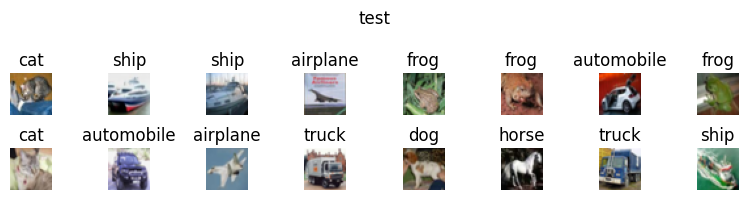

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# List of CIFAR-10 class names (in order of their indices)
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Example usage:
label = 3
print(f"Label {label} is class: {cifar10_classes[label]}")  # Output: cat

# For a batch of labels
labels = [3, 5, 8, 0]
names = [cifar10_classes[l] for l in labels]
print(names)  # Output: ['cat', 'dog', 'ship', 'airplane']

# CIFAR-10 mean and std
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])

def show_batch(images, labels=None, nrow=16,title = None):
    images = images[:nrow]
    plt.figure(figsize=(nrow//2,2))
    plt.suptitle(title)
    for i in range(len(images)):
        plt.subplot(2, nrow//2, i+1)
        image = images[i].numpy().transpose((1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        if labels is not None:
            plt.title(cifar10_classes[int(labels[i].item())])
        plt.axis('off')
    plt.tight_layout()

    plt.show()

images, labels = next(iter(testloader))
show_batch(images, labels, nrow=16,title = 'test')


In [ ]:
!ifconfig


In [ ]:
resnet.to(device)

**FGSM Attack Function**

In [ ]:
def fgsm_attack(model, images, labels, eps=0.3):
    images = images.to(device)
    labels = labels.to(device)
    model.to(device)
    loss = nn.CrossEntropyLoss()
    delta = torch.zeros_like(images)
    delta.to(device)
    delta.requires_grad = True

    model.eval()
    outputs = model(images+delta)

    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()

    adv_images = images + eps * delta.grad.sign()
    delta = torch.clamp(adv_images - images, min=-eps, max=eps)
    return adv_images,delta

**PGD attack function**

In [ ]:
def pgd_attack(model, images, labels, eps=0.1, alpha=0.03, iters=1) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
    eta = torch.zeros_like(images).to(device)
    model.eval()
    ori_images = images.data

    for i in range(iters) :
        eta.requires_grad = True
        outputs = model(images+eta)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        images = images + alpha*eta.grad.sign()
        eta = torch.clamp(images - ori_images, min=-eps, max=eps).detach()
    return images,eta

In [ ]:
batch_size = 128

In [ ]:
#asr = predicted

torch.float32


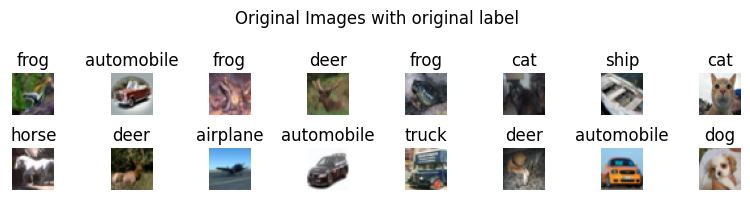

128


In [ ]:
images,label = next(iter(trainloader))
images = images.to(device)
label = label.to(device)
show_batch(images.cpu().detach(),label.cpu().detach(),nrow=16,title="Original Images with original label")

print(images.shape[0])


3.0537312030792236 -2.7290656566619873
torch.float32


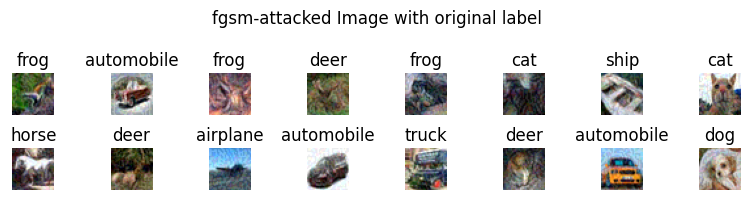

torch.float32


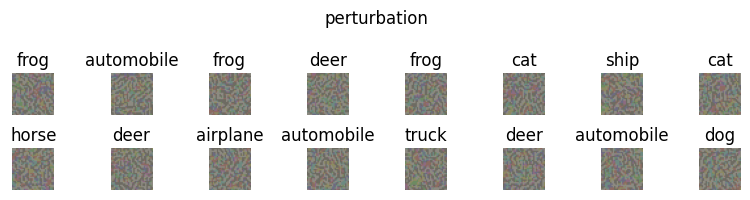

0.30000001192092896 3.682098181911897e-08


In [ ]:
fgsm_adv_images,perturbation = fgsm_attack(model = resnet,images = images,labels =label,eps = 0.03)
print(fgsm_adv_images.max().item(),fgsm_adv_images.min().item())
show_batch(fgsm_adv_images.detach().cpu(),label, title= "fgsm-attacked Image with original label")
show_batch(perturbation.detach().cpu(),label, title= "perturbation")
print(perturbation.abs().mean().item(),perturbation.abs().std().item())


torch.float32


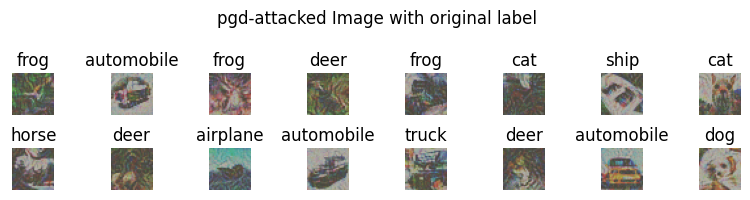

torch.float32


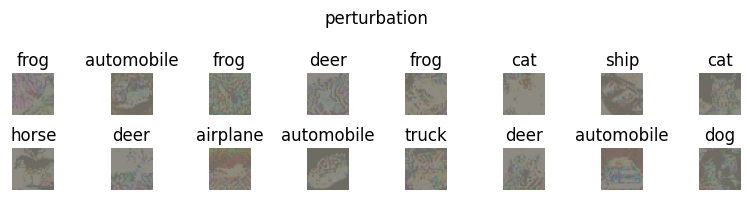

0.2317831814289093 0.10192698240280151


In [ ]:
pgd_adv_images,adv_perturbation = pgd_attack(model = resnet,images = images,labels =label,eps = 0.3,alpha=0.1
,iters = 10)
show_batch(pgd_adv_images.detach().cpu(),label, title= "pgd-attacked Image with original label")
show_batch(adv_perturbation.detach().cpu(),label, title= "perturbation")
print(adv_perturbation.abs().mean().item(),adv_perturbation.abs().std().item())


torch.float32


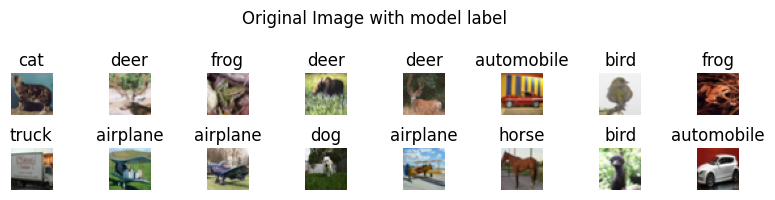

In [ ]:
model_label = resnet(images.to(device)).argmax(dim=1)
show_batch(images.cpu().detach(),model_label.cpu().detach(), title = "Original Image with model label")

torch.float32


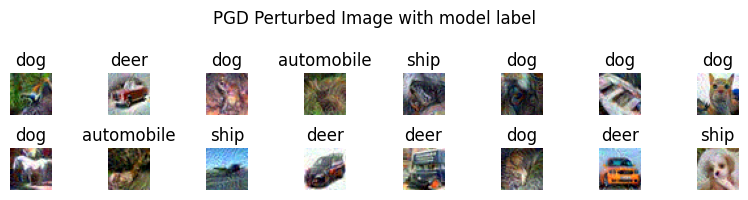

In [ ]:
with torch.no_grad():
    avd_outputs = resnet(pgd_adv_images.to(device))
    avd_pred = avd_outputs.argmax(dim=1)
    perturbation_label = resnet(perturbation.to(device)).argmax(dim=1)
    show_batch(pgd_adv_images.cpu().detach(),avd_pred.cpu().detach(), title = "PGD Perturbed Image with model label")


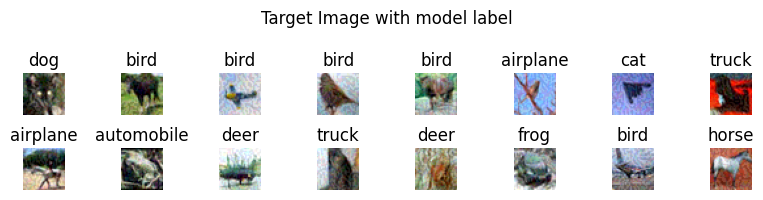

In [ ]:
target_adv_image,perturbation = fgsm_attack(resnet,images,label)
with torch.no_grad():
    target_adv_outputs = resnet(target_adv_image.to(device))
    target_adv_pred = target_adv_outputs.argmax(dim=1)
    show_batch(target_adv_image.cpu().detach(),target_adv_pred.cpu().detach(), title = "Target Image with model label")

In [ ]:
def non_targeted_fgsm_ASR(dataloader,model,device,eps = 0.03):
    model.eval()
    attack_success_count = 0
    total_images = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    for image,label in tqdm(dataloader):
        image,ori_label = image.to(device),label.to(device)
        model_label = model(image).argmax(dim=1)
        perturbed_image,perturbation = fgsm_attack(model,image,label.to(device),eps=eps)
        attacked_label = model(perturbed_image).argmax(dim=1)

        attack_success_count += (attacked_label != ori_label).sum().item()
        total_images += image.size(0)
        running_loss += criterion(model(perturbed_image),ori_label).item()
    running_loss/=len(dataloader)
    return attack_success_count/total_images,running_loss

In [ ]:
fgsm_ASR,fgsm_test_loss = non_targeted_fgsm_ASR(testloader,resnet,device)
print(f"test fgsm ASR: {fgsm_ASR}, fgsm loss: {fgsm_test_loss} \n")
fgsm_ASR,fgsm_train_loss = non_targeted_fgsm_ASR(trainloader,resnet,device)
print(f"trainASR: {fgsm_ASR}, fgsm loss: {fgsm_train_loss} \n")


100%|██████████| 79/79 [00:05<00:00, 15.79it/s]


test fgsm ASR: 0.9232, fgsm loss: 6.980310947080202 



100%|██████████| 391/391 [00:21<00:00, 18.03it/s]

trainASR: 0.9026, fgsm loss: 5.853895253232678 



In [ ]:
def non_targeted_pgd_ASR(dataloader,model,device,eps,iters=10):
    model.eval()
    attack_success_count = 0
    total_images = 0
    criterion = nn.CrossEntropyLoss()

    for image,label in tqdm(dataloader):
        image,ori_label = image.to(device), label.to(device)
        model_label = model(image).argmax(dim=1)
        perturbed_image,perturbation = pgd_attack(model,image,label.to(device),eps = eps,iters =iters)

        perturbed_image = (image + perturbation).to(device)
        attacked_label = model(perturbed_image).argmax(dim=1)

        attack_success_count += (attacked_label != ori_label).sum().item()
        total_images += image.size(0)
    return attack_success_count/total_images

In [ ]:
pgd_ASR = non_targeted_pgd_ASR(testloader,resnet,device,eps = 0.03,iters = 5)
print(f"test pgd ASR: {pgd_ASR:.4f}")
pgd_ASR = non_targeted_pgd_ASR(trainloader,resnet,device,eps = 0.03,iters = 5)
print(f"train pgd ASR: {pgd_ASR:.4f}")


100%|██████████| 79/79 [00:09<00:00,  8.40it/s]


test pgd ASR: 0.9000


 78%|███████▊  | 304/391 [00:35<00:10,  8.50it/s]


KeyboardInterrupt: 

In [ ]:
varying_eps_ASR = []

for i in range(0,10):
    varying_eps_ASR.append(non_targeted_pgd_ASR(testloader,resnet,device,eps = i/10,iters = 10))



100%|██████████| 79/79 [00:07<00:00, 10.12it/s]


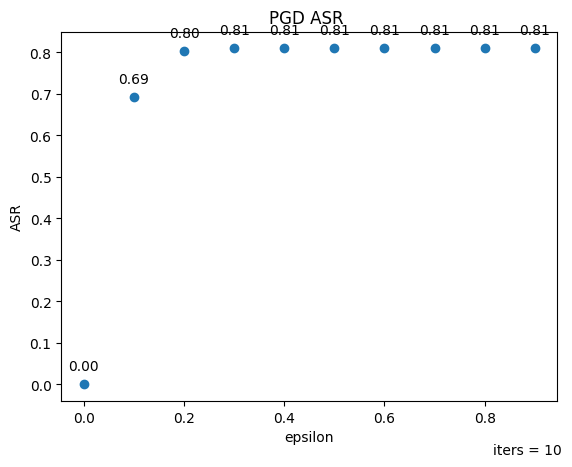

In [ ]:
eps = [i/10 for i in range(0,10)]
plt.scatter(x = eps,y=varying_eps_ASR)
plt.title("PGD ASR ")
plt.xlabel("epsilon")
plt.ylabel("ASR")
plt.figtext(x = 0.8, y = 0,s= "iters = 10")

for i, txt in enumerate(varying_eps_ASR):
    plt.annotate(f"{txt:.2f}", (eps[i], varying_eps_ASR[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [ ]:
vary_iter_ASR = []
for i in range(0,8):
    vary_iter_ASR.append(non_targeted_pgd_ASR(testloader,resnet,device,iters = (1+i)*(5),eps = 0.3))


100%|██████████| 79/79 [00:28<00:00,  2.79it/s]


8


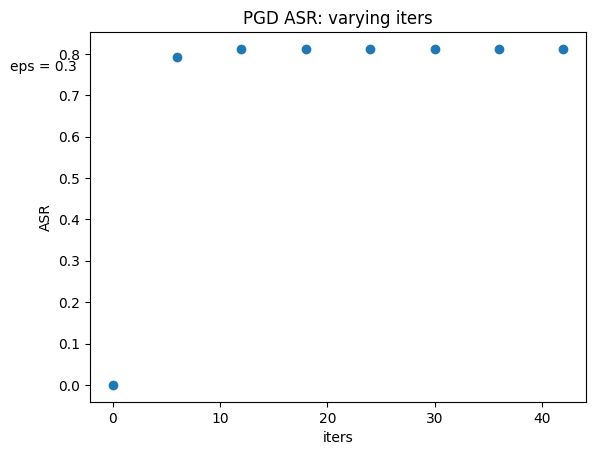

In [ ]:
# ASR[0] = non_targeted_pgd_ASR(testloader,resnet,device,iters = 5,eps = 0.3)
print(len(vary_iter_ASR))
plt.scatter(x = [(1+i)*(5) for i in range(8)],y=vary_iter_ASR)
plt.title("PGD ASR: varying iters")
plt.xlabel("iters")
plt.ylabel("ASR")
plt.figtext(0,0.8,"eps = 0.3")
plt.show()

In [ ]:
def adv_train(model, trainloader,testloader, criterion, optimizer, device,scheduler, num_iter,attack):
    model.to(device) # Ensure model is on the correct device inside the function
    test_best_loss = float('inf')
    test_best_acc = 0.0
    model.train()
    test_num_correct = 0
    train_num_correct = 0

    for epoch in range(num_iter):
          model.train()
          running_loss = 0.0
          num_train_samples = 0
          train_num_correct = 0

          test_loss = 0.0
          num_test_samples = 0
          test_num_correct = 0

          for images, labels in tqdm(trainloader):
              images,labels = images.to(device), labels.to(device)
              adv_images,perturbation = fgsm_attack(model,images,labels,eps = 0.04)

              images = torch.cat((images,adv_images),dim=0)
              labels = torch.cat((labels,labels),dim=0)

              optimizer.zero_grad()
              outputs = model(images)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              num_train_samples += images.size(0)
              running_loss += loss.item()
              train_num_correct += (outputs.argmax(dim=1) == labels).sum().item()
          train_acc = train_num_correct/num_train_samples

          model.eval()
          for image,labels in tqdm(testloader):
              image,labels = image.to(device), labels.to(device)
              outputs = model(image)
              loss = criterion(outputs,labels)
              test_loss += loss.item()
              test_num_correct += (outputs.argmax(dim=1) == labels).sum().item()
              num_test_samples += image.size(0)
          scheduler.step()
          test_acc = test_num_correct/num_test_samples
          test_loss /= (2*len(testloader))
          running_loss /= (2*len(trainloader))


          print(f"Epoch {epoch+1}, train Loss: {running_loss:.4f} \n")
          print(f"Epoch {epoch+1}, test loss: {test_loss:.4f}\n")


          #print(f"Model is on device: {next(model.parameters()).device}")
          print(f"Epoch {epoch+1},Test Accuracy: {test_acc:.4f} \n")


          if(test_best_loss > test_loss  or test_best_acc < test_acc):
            test_best_loss = test_loss
            test_best_acc = test_acc
            print("saving model's weight \n")
            torch.save(model.state_dict(), 'more_robust_model_weights.pth')

          print(f"Epoch {epoch+1}, Train Accuracy: {train_acc} \n")
          #print(f"Images are on device: {images.device}")


In [ ]:
resnet.load_state_dict(torch.load('model_weights.pth'))
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=280)
criterion = nn.CrossEntropyLoss()
adv_train(resnet, trainloader, testloader,criterion, optimizer, device,scheduler, num_iter=20,attack = fgsm_attack)

100%|██████████| 79/79 [00:03<00:00, 21.51it/s]


Epoch 1, train Loss: 0.4186 

Epoch 1, test loss: 0.3736

Epoch 1,Test Accuracy: 0.7491 

saving model's weight 

Epoch 1, Train Accuracy: 0.71211 



100%|██████████| 79/79 [00:02<00:00, 28.06it/s]


Epoch 2, train Loss: 0.2968 

Epoch 2, test loss: 0.3696

Epoch 2,Test Accuracy: 0.7573 

saving model's weight 

Epoch 2, Train Accuracy: 0.78864 



100%|██████████| 79/79 [00:02<00:00, 31.29it/s]


Epoch 3, train Loss: 0.2327 

Epoch 3, test loss: 0.3851

Epoch 3,Test Accuracy: 0.7559 

Epoch 3, Train Accuracy: 0.83133 



100%|██████████| 79/79 [00:02<00:00, 30.97it/s]


Epoch 4, train Loss: 0.1930 

Epoch 4, test loss: 0.3761

Epoch 4,Test Accuracy: 0.7703 

saving model's weight 

Epoch 4, Train Accuracy: 0.85786 



100%|██████████| 79/79 [00:02<00:00, 30.80it/s]


Epoch 5, train Loss: 0.1616 

Epoch 5, test loss: 0.3938

Epoch 5,Test Accuracy: 0.7674 

Epoch 5, Train Accuracy: 0.87959 



100%|██████████| 79/79 [00:02<00:00, 27.71it/s]


Epoch 6, train Loss: 0.1355 

Epoch 6, test loss: 0.4179

Epoch 6,Test Accuracy: 0.7717 

saving model's weight 

Epoch 6, Train Accuracy: 0.89855 



100%|██████████| 79/79 [00:03<00:00, 22.05it/s]


Epoch 7, train Loss: 0.1203 

Epoch 7, test loss: 0.4163

Epoch 7,Test Accuracy: 0.7621 

saving model's weight 

Epoch 7, Train Accuracy: 0.90995 



100%|██████████| 79/79 [00:02<00:00, 31.54it/s]


Epoch 8, train Loss: 0.1079 

Epoch 8, test loss: 0.4178

Epoch 8,Test Accuracy: 0.7733 

saving model's weight 

Epoch 8, Train Accuracy: 0.9191 



100%|██████████| 79/79 [00:02<00:00, 30.73it/s]


Epoch 9, train Loss: 0.0887 

Epoch 9, test loss: 0.4650

Epoch 9,Test Accuracy: 0.7675 

Epoch 9, Train Accuracy: 0.93351 



100%|██████████| 79/79 [00:02<00:00, 30.37it/s]


Epoch 10, train Loss: 0.0849 

Epoch 10, test loss: 0.4926

Epoch 10,Test Accuracy: 0.7699 

Epoch 10, Train Accuracy: 0.9365 



100%|██████████| 79/79 [00:02<00:00, 30.01it/s]


Epoch 11, train Loss: 0.0783 

Epoch 11, test loss: 0.4762

Epoch 11,Test Accuracy: 0.7655 

Epoch 11, Train Accuracy: 0.94145 



100%|██████████| 79/79 [00:03<00:00, 24.44it/s]


Epoch 12, train Loss: 0.0678 

Epoch 12, test loss: 0.4925

Epoch 12,Test Accuracy: 0.7714 

Epoch 12, Train Accuracy: 0.94905 



100%|██████████| 79/79 [00:03<00:00, 22.72it/s]


Epoch 13, train Loss: 0.0640 

Epoch 13, test loss: 0.4937

Epoch 13,Test Accuracy: 0.7663 

Epoch 13, Train Accuracy: 0.95189 



100%|██████████| 79/79 [00:02<00:00, 30.82it/s]


Epoch 14, train Loss: 0.0603 

Epoch 14, test loss: 0.5413

Epoch 14,Test Accuracy: 0.7627 

Epoch 14, Train Accuracy: 0.95518 



100%|██████████| 79/79 [00:02<00:00, 30.30it/s]


Epoch 15, train Loss: 0.0581 

Epoch 15, test loss: 0.5330

Epoch 15,Test Accuracy: 0.7618 

Epoch 15, Train Accuracy: 0.95649 



100%|██████████| 79/79 [00:02<00:00, 30.43it/s]


Epoch 16, train Loss: 0.0550 

Epoch 16, test loss: 0.5344

Epoch 16,Test Accuracy: 0.7620 

Epoch 16, Train Accuracy: 0.95939 



100%|██████████| 79/79 [00:02<00:00, 30.48it/s]


Epoch 17, train Loss: 0.0505 

Epoch 17, test loss: 0.5825

Epoch 17,Test Accuracy: 0.7625 

Epoch 17, Train Accuracy: 0.96297 



100%|██████████| 79/79 [00:03<00:00, 25.95it/s]


Epoch 18, train Loss: 0.0495 

Epoch 18, test loss: 0.5516

Epoch 18,Test Accuracy: 0.7669 

Epoch 18, Train Accuracy: 0.96361 



100%|██████████| 79/79 [00:03<00:00, 23.17it/s]


Epoch 19, train Loss: 0.0478 

Epoch 19, test loss: 0.5401

Epoch 19,Test Accuracy: 0.7716 

Epoch 19, Train Accuracy: 0.96465 



100%|██████████| 79/79 [00:02<00:00, 30.86it/s]

Epoch 20, train Loss: 0.0443 

Epoch 20, test loss: 0.5970

Epoch 20,Test Accuracy: 0.7641 

Epoch 20, Train Accuracy: 0.96758 



In [ ]:
robust_renest = models.resnet18(pretrained=True)
robust_renest.fc = nn.Linear(robust_renest.fc.in_features, 10)

robust_renest.load_state_dict(torch.load('more_robust_model_weights.pth'))
robust_renest.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
fgsm_attack_ASR,fgsm_test_loss = non_targeted_fgsm_ASR(testloader,robust_renest,device,eps = 0.03)
print(f"test fgsm ASR: {fgsm_attack_ASR}, fgsm loss: {fgsm_test_loss} \n")


100%|██████████| 79/79 [00:04<00:00, 18.21it/s]

test fgsm ASR: 0.4133, fgsm loss: 1.7502710336371312 



In [ ]:
fgsm_attack_ASR,fgsm_train_loss = non_targeted_fgsm_ASR(trainloader,robust_renest,device,eps = 0.03)
print(f"trainASR: {fgsm_attack_ASR}, fgsm loss: {fgsm_train_loss} \n")

100%|██████████| 391/391 [00:21<00:00, 18.49it/s]

trainASR: 0.05666, fgsm loss: 0.16608387793954985 



In [ ]:
acc,precision,recall = check_accuracy(robust_renest,testloader,device)
print(f"Test Accuracy: {acc} \n"
    f"Test Recall: {recall} \n"
    f"Test Percision: {precision}\n")

Test Accuracy: 0.7733 
Test Recall: 0.7733 
Test Percision: 0.7755958112816846

